In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredText
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import AnchoredText

import geopy.distance
import datetime
import netCDF4 as netcdf
from tqdm import tqdm
import os
from kalpana.export import pointsInsidePoly, readSubDomain
from kalpana.tools import readNodes_fort14
import geopandas as gpd
from shapely.geometry import Polygon

from concorde.tools import readFort22, get_list, ssScale
from concorde.plots import *
from kalpana.export import getDates
# plt.style.use('seaborn-v0_8-whitegrid')

import sys
sys.path.append(r'/home/tacuevas/github/ADCIRCtools/ADCIRCtools')
# from functions import subsetMeshGdf
from scipy.spatial.distance import cdist
from scipy import interpolate

ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'font.size': 12})
import cmocean
import tcmarkers

#### Functions

In [2]:
def subsetMeshGdf2(gdf, nodes, mask, out=True):
    '''  Subsets a geodataframe based on a mask polygon and returns matplotlib triangulation,
         the nodes outside the mask, and a geodataframe with the mesh subset. It is important to note
         that the part of the mesh inside the mask is removed.
         
         Parameters
            gdf: geopandas GeoDataFrame
                mesh gdf, each element is an individual polygon. Output of fort14togdf function
            nodes: pandas dataframe
                mesh nodes, output of readNodes_fort14 function
            mask: geopandas GeoDataFrame
                mask gdf, output of readSubDomain function.
            out: boolean. Default True
                True for keeping nodes outside mask, False for keeping nodes inside.
        Returns
            newMeshTri: matplotlib triangulation object
                subset of the mesh triangulation
            meshSub: geopandas GeoDataFrame
                mesh subset gdf, each element is an individual polygon.
            dfNodesOutside: pandas dataframe
                coordinates of the nodes outside the mask (new mesh nodes). Dataframe index
                starts from 0, has x, y and z values, and the index of the node in the original mesh
    '''
    # Extract exterior coordinates of the mask polygon
    xAux, yAux = mask.geometry[0].exterior.coords.xy
    extCoords = list(zip(xAux, yAux))
    # Get centroids of mesh elements
    centroids = list(zip(gdf['centX'], gdf['centY']))
    # Determine which centroids are inside the mask polygon
    inside = pointsInsidePoly(centroids, extCoords)
    # Get indices of elements to keep (outside the mask polygon)
    # starts from 0 and not from 1 as ADCIRC nodes
    if out == True:
        centToKeep = np.where(inside == False)[0]
    else:
        centToKeep = np.where(inside == True)[0]
    # Subset the geodataframe based on the selected elements, the index starts from 0
    # so iloc or loc gives same result
    meshSub = gdf.iloc[centToKeep, :]
    # get nodes of the elements to keep, starts from 0
    nodesToKeep = meshSub.loc[:, ['v1', 'v2', 'v3']].values.reshape(-1)
    # remove repeated nodes
    nodesToKeep = np.unique(nodesToKeep)
    # get coordinates of nodes to keep, the index of the series correspond to the
    # full mesh
    xNodesToKeep = nodes.iloc[nodesToKeep, 0]
    yNodesToKeep = nodes.iloc[nodesToKeep, 1]
    zNodesToKeep = nodes.iloc[nodesToKeep, 2]
    # Create a lookup table for renumering the mesh
    aux = {value: index for index, value in enumerate(list(nodesToKeep))}
    # find index of each element vertex in the list nodes to keep
    newV = [(aux[x], aux[y], aux[z]) for x, y, z in zip(meshSub['v1'], meshSub['v2'], meshSub['v3'])]
    # Create a triangulation based on the subsetted nodes and elements
    newMeshTri = mpl.tri.Triangulation(xNodesToKeep, yNodesToKeep, newV)
    # add new element's nodes to the geodataframe
    meshSub[['v1u', 'v2u', 'v3u']] = newV
    meshSub.index = range(len(meshSub))
    ## dataframe with new mesh nodes
    dfNodesToKeep = pd.DataFrame({'x': xNodesToKeep.values,
                                   'y': yNodesToKeep.values,
                                   'z': zNodesToKeep.values,
                                   'orgIndex': xNodesToKeep.index})

    return newMeshTri, meshSub, dfNodesToKeep

#### Run time and logFiles

In [3]:
dflogs = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/logFiles_COMPLETE_batch02_200923.csv', index_col = 0)
dflogs.head()

run         dt    status       log  nodeElevWarning  nodeSpeedWarning  \
0    0   0.000000  complete  0.219652              NaN               NaN   
2    1  10.924167  complete  1.719080              NaN               NaN   
3    2   0.000000  complete  2.219652              NaN               NaN   
4    3   0.000000  complete  3.219652              NaN               NaN   
5    4   0.000000  complete  4.219652              NaN               NaN   

  perWarning batch  ncores  orgInidex  ncores2        dt2  
0        NaN    01     0.0          0      256   2.488056  
2        NaN    02     0.0          0      192  10.924167  
3        NaN    01     0.0          2      256   7.276944  
4        NaN    01     0.0          3      256   2.216389  
5        NaN    01     0.0          4      256   3.177500

In [4]:
## amount of data approx
3500 + 3800 + 8000 + 425 + 1400

17125

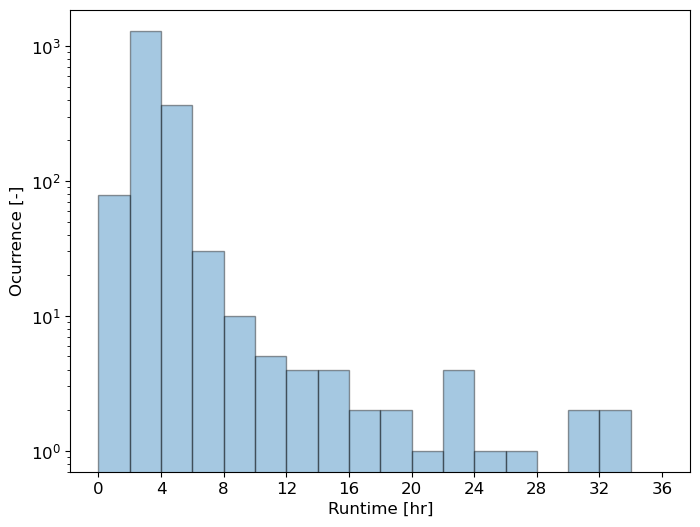

In [7]:
fig, ax = plt.subplots(figsize = (8, 6))
dflogs['dt2'].plot.hist(alpha = 0.4, edgecolor = 'k', bins = np.arange(0, 38, 2));
ax.set_xticks(np.arange(0, 38, 4));
ax.set_ylabel('Ocurrence [-]')
ax.set_xlabel('Runtime [hr]');
# ax.grid(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax.set_yscale('log')
# text1 = f"Av. wall clock time [hr] ~ {dflogs['dt2'].mean():0.2f} hrs"
# text2 = f"Total cpu hours ~ {(dflogs['dt2']*dflogs['ncores2']).sum()/1e6:0.1f}M"
# atext = AnchoredText(f'{text1}\n{text2}', loc = 1, frameon = True)
# ax.add_artist(atext)
# fig.savefig(r'../documents/waves_and_storm_surge/histogram_runtimes.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/histogram_runtimes.png', dpi = 300, bbox_inches = 'tight')

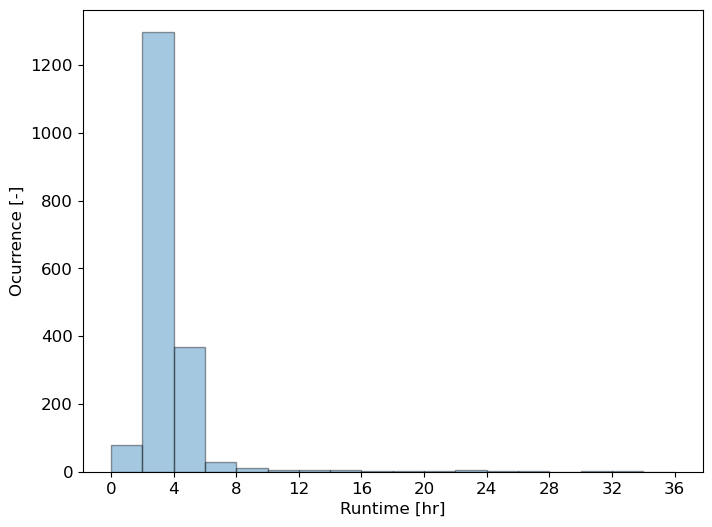

In [4]:
fig, ax = plt.subplots(figsize = (8, 6))
dflogs['dt2'].plot.hist(alpha = 0.4, edgecolor = 'k', bins = np.arange(0, 38, 2));
ax.set_xticks(np.arange(0, 38, 4));
ax.set_ylabel('Ocurrence [-]')
ax.set_xlabel('Runtime [hr]');
# ax.set_yscale('log')
# fig.savefig(r'..//documents/thesis/histogram_runtimes.png', dpi = 300, bbox_inches = 'tight')

In [4]:
dflogs.loc[[dflogs['dt2'].idxmin()], :]

run   dt    status       log  nodeElevWarning  nodeSpeedWarning  \
117   79  0.0  complete  79.21966              NaN               NaN   

    perWarning batch  ncores  orgInidex  ncores2       dt2  
117        NaN    01     0.0         79      256  1.230278

In [3]:
print(f"Min wall clock time: {dflogs['dt2'].min()} hours")
print(f"Mean wall clock time: {dflogs['dt2'].mean()} hours")
print(f"Max wall clock time: {dflogs['dt2'].max()} hours")
print(f"Total wall clock time: {dflogs['dt2'].sum()/24/30} months")
print(f"Total CPU hours: {(dflogs['dt2']*dflogs['ncores2']).sum()}")

Min wall clock time: 1.2302777777777778 hours
Mean wall clock time: 3.7493097689526262 hours
Max wall clock time: 33.34361111111111 hours
Total wall clock time: 9.440970293209878 months
Total CPU hours: 1337443.9111111113


#### Read Storms

In [2]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing')
dfMaxNC = pd.read_pickle(pathin/'max_water_level_NC.pkl')

gdfMaxNC = gpd.GeoDataFrame(geometry = [Point((x, y)) for x,y in zip(dfMaxNC['x'], dfMaxNC['y'])], crs = 4326)
gdfMaxNC['zeta_max'] = dfMaxNC['zeta_max'].values
gdfMaxNC.to_file(pathin/'max_water_level_NC.gpkg', driver = 'GPKG')

dfMaxNC = dfMaxNC.drop('base', axis = 0) ## drop base, only tides simulation

In [3]:
dfMaxNC_corr = dfMaxNC[dfMaxNC['zeta_max'] < 10]
dfMaxNC_corr.describe().T

count       mean       std        min        25%        50%  \
x         1793.0 -77.282211  1.034402 -78.770641 -78.542669 -76.970170   
y         1793.0  34.846900  0.886250  33.770306  33.879082  34.892439   
zeta_max  1793.0   2.958725  1.430571   0.642015   1.736058   2.780928   

                75%        max  
x        -76.572205 -75.460766  
y         35.473503  36.736682  
zeta_max   3.750282   9.649301

In [4]:
dfMaxNC_corr.head()

x          y  zeta_max
0000 -76.737441  35.356003  6.464966
0001 -78.756484  33.778052  1.425744
0002 -76.415619  34.926268  1.848535
0003 -75.905511  36.661050  1.721653
0004 -77.953116  34.213106  1.375811

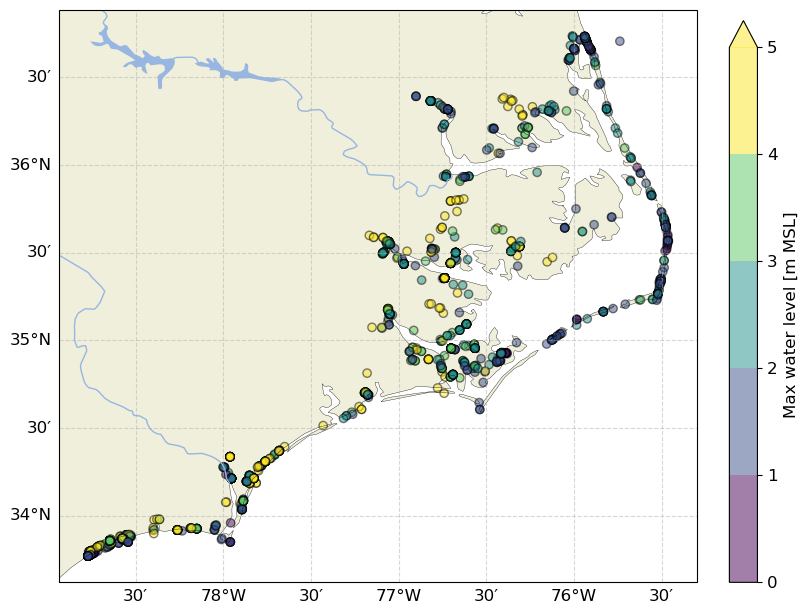

In [25]:
cmap = plt.cm.viridis#cmocean.cm.tempo
norm = colors.BoundaryNorm(np.arange(0, 6, 1), cmap.N)
fig, ax = plt.subplots(figsize = (8, 8), nrows = 1, ncols = 1, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
sc = ax.scatter(dfMaxNC['x'], dfMaxNC['y'], c = dfMaxNC['zeta_max'], cmap = cmap, norm = norm, edgecolors='k', alpha = 0.5)
cb = fig.colorbar(sc, fraction = 0.044, extend="max")
cb.set_label('Max water level [m MSL]')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
# fig.savefig(r'../documents/waves_and_storm_surge/2Dmap_max_water_level_NC.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/2Dmap_max_water_level_NC.png', dpi = 300, bbox_inches = 'tight')

In [5]:
gdfTracksIn = gpd.read_file(r'../gis/gpkg/tracks_STORM_batch02_In.gpkg')
dfTracksIn = pd.read_pickle(r'../data/STORM/processed/batch02/STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')
dctWaverLevelNOAA = pd.read_pickle(r'../models/adcirc/concorde/batch02/_postprocessing/time_series_water_level_at_NOAA_NC.pkl')
dfWaverLevelNOAAbase = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/time_series_water_level_at_NOAA_NC_baseSim.csv', index_col = 0, parse_dates = True)

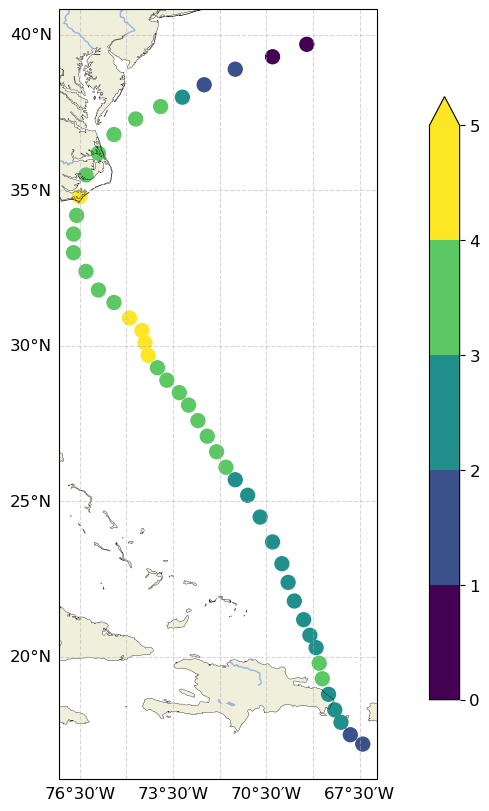

In [40]:
dummy = dfTracksIn[dfTracksIn['runIndex'] == 383]
cmap = plt.cm.viridis#cmocean.cm.tempo
norm = colors.BoundaryNorm(np.arange(0, 6, 1), cmap.N)
fig, ax = plt.subplots(figsize = (8, 8), nrows = 1, ncols = 1, subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
sc = ax.scatter(dummy['lon'], dummy['lat'], c = dummy['cat'], cmap = cmap, norm = norm, 
                 s = 100)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') # show coordinates and grig
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
cb = fig.colorbar(sc, fraction = 0.044, extend="max")

In [3]:
ys = [36.183, 35.795, 35.209, 34.717, 34.227, 34.213]
xs = [-75.745, -75.548, -75.704, -76.67, -77.953, -77.787]
names = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

In [4]:
def readFort22(pathIn):
    f22 = pd.read_csv(pathIn, header = None)
    f22.index = [datetime.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8]), int(str(x)[8:10])) for x in f22.iloc[:, 2]]
    f22['lon'] = [-1*int(x[:-1])/10 for x in f22.iloc[:, 7]]
    f22['lat'] = [int(x[:-1])/10 for x in f22.iloc[:, 6]]
    f22['wind_speed'] = [x/1.94384 for x in f22.iloc[:, 8]]
    f22['pressure'] = [x for x in f22.iloc[:, 9]]
    f22['rad_to_max_ws'] = [x for x in f22.iloc[:, 19]]
    f22 = f22[['lon', 'lat', 'wind_speed', 'pressure', 'rad_to_max_ws']]
    return f22

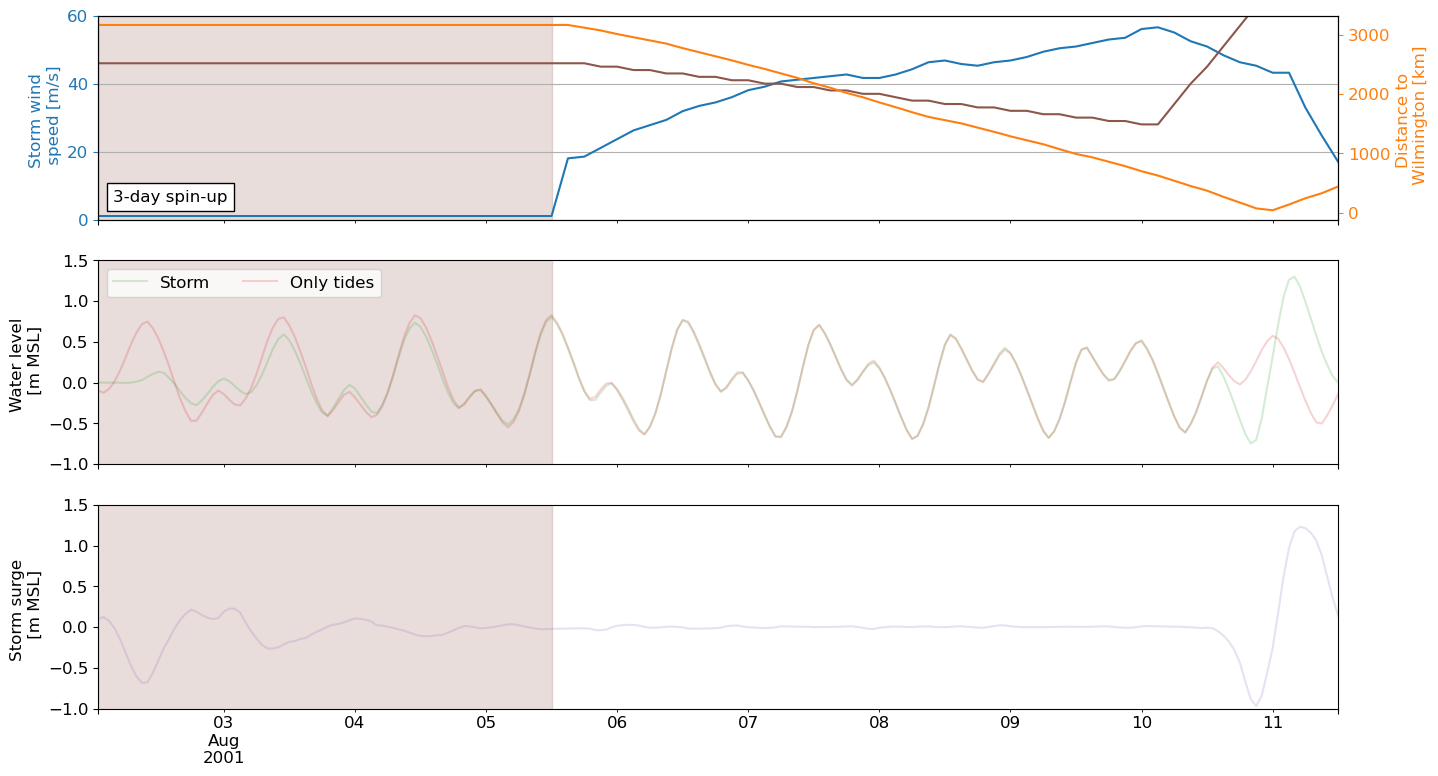

In [8]:
pointToPlot = 'pnt004'
f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0000']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_pnt004'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                      'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                      'ws': f22_res['wind_speed'].values[1:],
                      'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:],
                      'rmws': f22_res['rad_to_max_ws']}, index = dfNOAAplot.index)


fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2], alpha = 0.2)
dummy['tides'].plot(ax = ax[1], color = ccolors[3], alpha = 0.2)
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.arange(0, 80, 20));
ax[0].right_ax.grid(False)
ax[0].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Wilmington [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 2, 0.5));
ax[1].set_ylim([-1.0, 1.5])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 2, 0.5));
ax[2].set_ylim([-1.0, 1.5])
ax[2].set_ylabel('Storm surge \n [m MSL]')
anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
ax[1].legend(['Storm', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/waves_and_storm_surge/time_series_run0000_a.png', dpi = 300, bbox_inches = 'tight')

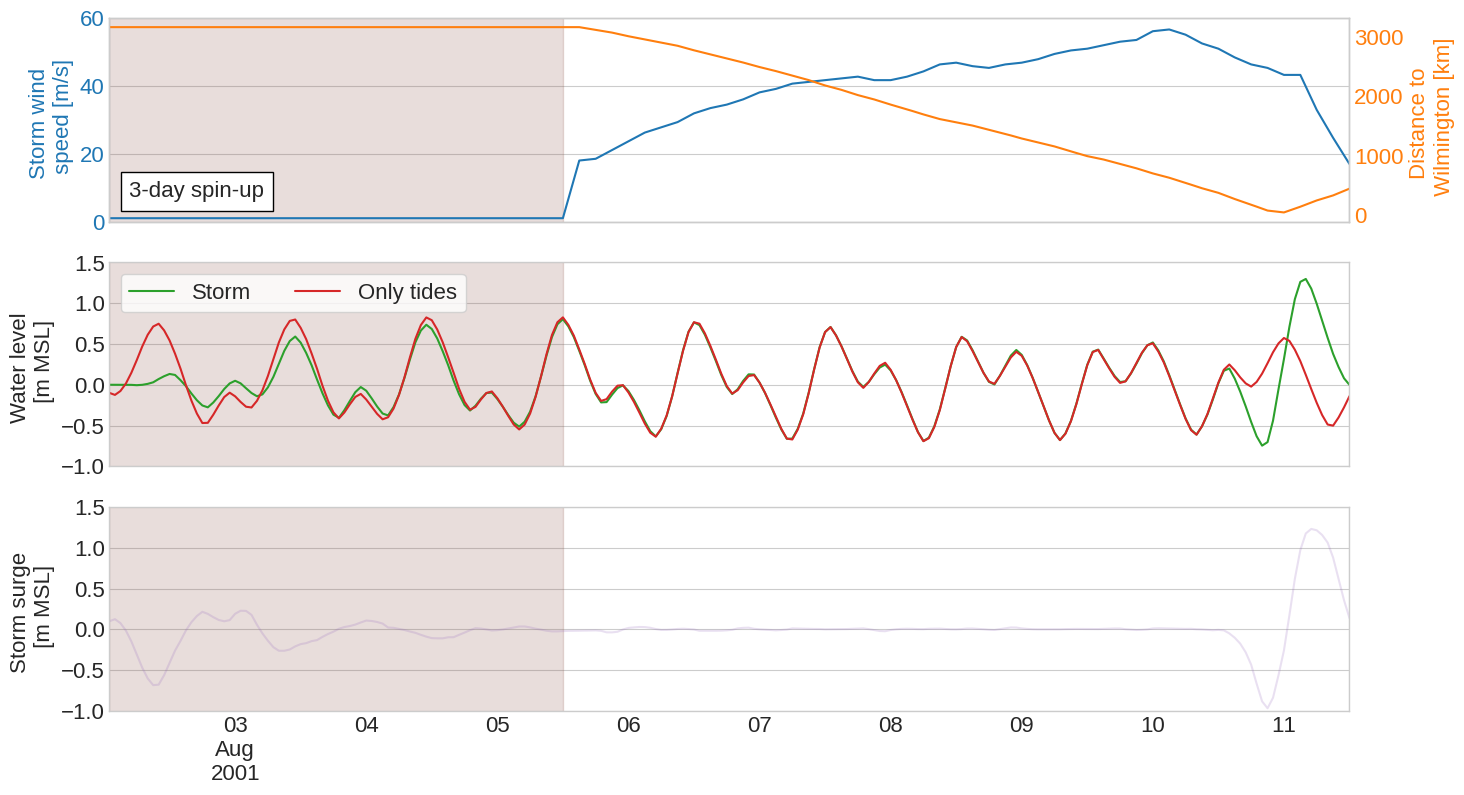

In [12]:
pointToPlot = 'pnt004'
f22 = readFort22(r'/media/tomas/SSD_tomas/thesis/wind/0000/fort.22')#/media/tacuevas/Extreme SSD/batch02/0000/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0000']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_pnt004'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                      'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                      'ws': f22_res['wind_speed'].values[1:],
                      'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]}, index = dfNOAAplot.index)


fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2], alpha = 1)
dummy['tides'].plot(ax = ax[1], color = ccolors[3], alpha = 1)
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.arange(0, 80, 20));
ax[0].right_ax.grid(False)
ax[0].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Wilmington [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 2, 0.5));
ax[1].set_ylim([-1.0, 1.5])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 2, 0.5));
ax[2].set_ylim([-1.0, 1.5])
ax[2].set_ylabel('Storm surge \n [m MSL]')
anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
ax[1].legend(['Storm', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
fig.savefig(r'../documents/waves_and_storm_surge/time_series_run0000_b.png', dpi = 300, bbox_inches = 'tight')

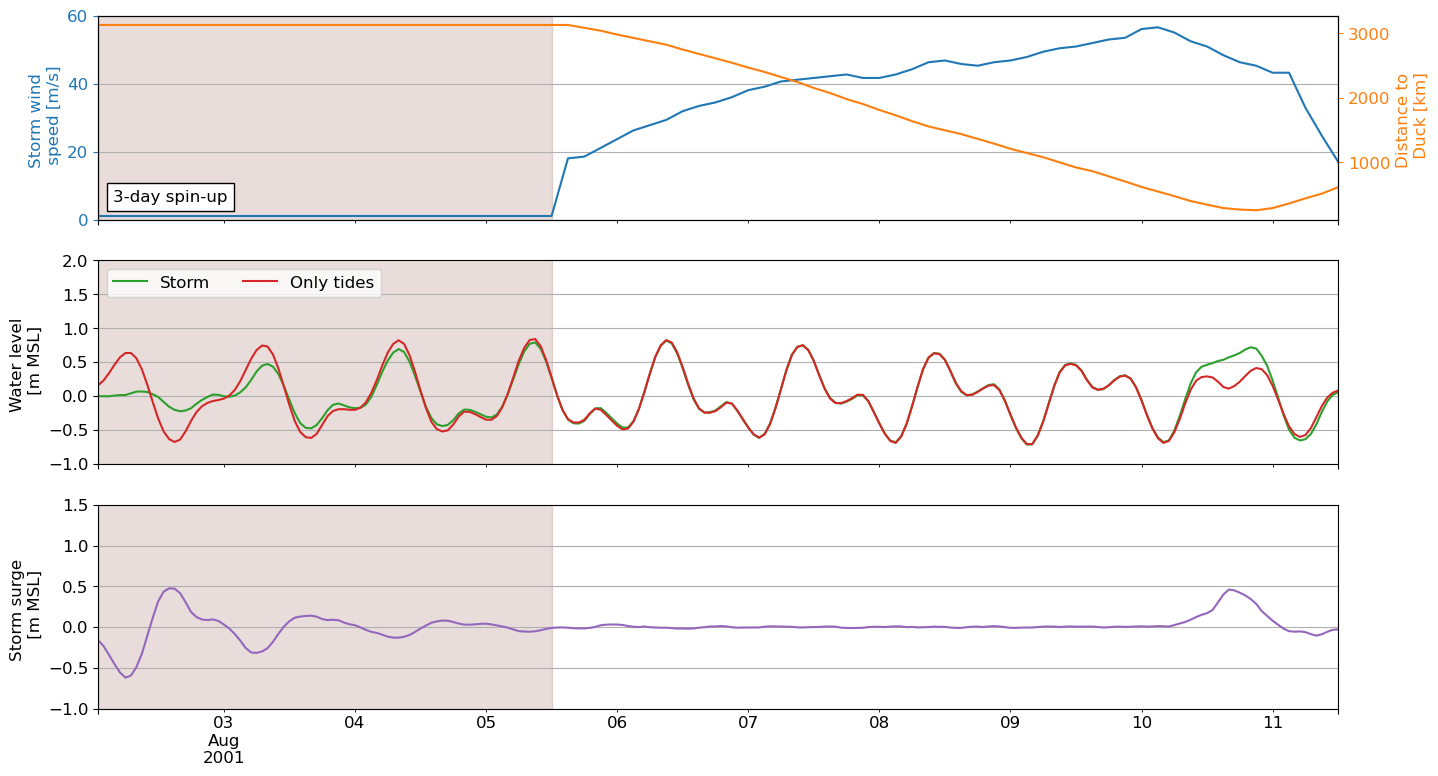

In [13]:
pointToPlot = 'pnt000'
f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0000']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_{pointToPlot}'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                      'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                      'ws': f22_res['wind_speed'].values[1:],
                      'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]}, index = dfNOAAplot.index)


fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2], alpha = 1)
dummy['tides'].plot(ax = ax[1], color = ccolors[3], alpha = 1)
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 1)

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.arange(0, 80, 20));
ax[0].right_ax.grid(False)
ax[0].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Duck [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 2.5, 0.5));
ax[1].set_ylim([-1.0, 2])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[1].grid(True)
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 2, 0.5));
ax[2].set_ylim([-1.0, 1.5])
ax[2].set_ylabel('Storm surge \n [m MSL]')
ax[2].grid(True)

anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
ax[1].legend(['Storm', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/waves_and_storm_surge/time_series_run0000_c.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/time_series_run0000_duck.png', dpi = 300, bbox_inches = 'tight')

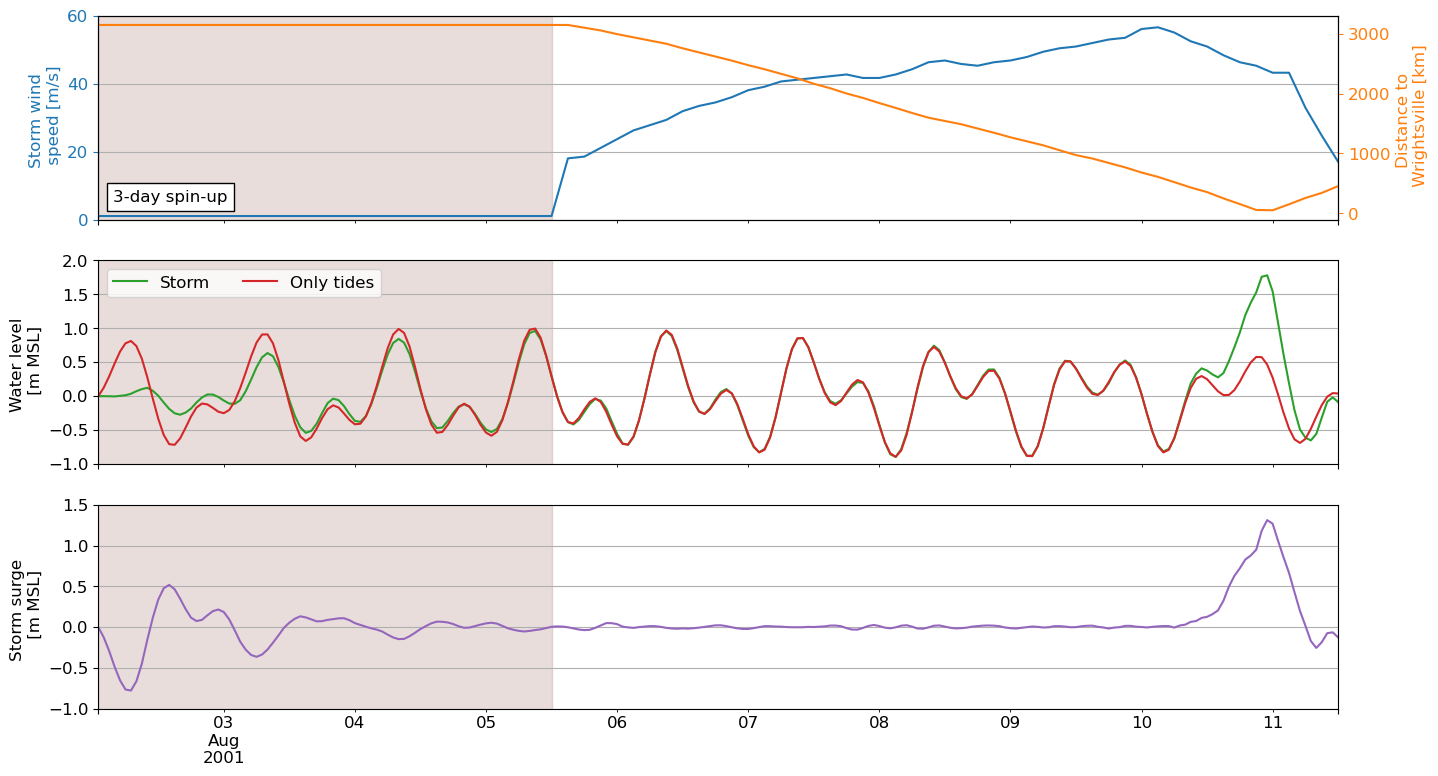

In [12]:
pointToPlot = 'pnt005'
f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0000']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_{pointToPlot}'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                      'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                      'ws': f22_res['wind_speed'].values[1:],
                      'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]}, index = dfNOAAplot.index)


fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2], alpha = 1)
dummy['tides'].plot(ax = ax[1], color = ccolors[3], alpha = 1)
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 1)

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.arange(0, 80, 20));
ax[0].right_ax.grid(False)
ax[0].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 2.5, 0.5));
ax[1].set_ylim([-1.0, 2])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[1].grid(True)
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 2, 0.5));
ax[2].set_ylim([-1.0, 1.5])
ax[2].set_ylabel('Storm surge \n [m MSL]')
ax[2].grid(True)

anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
ax[1].legend(['Storm', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/waves_and_storm_surge/time_series_run0000_c.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/time_series_run0000_wrightsville.png', dpi = 300, bbox_inches = 'tight')

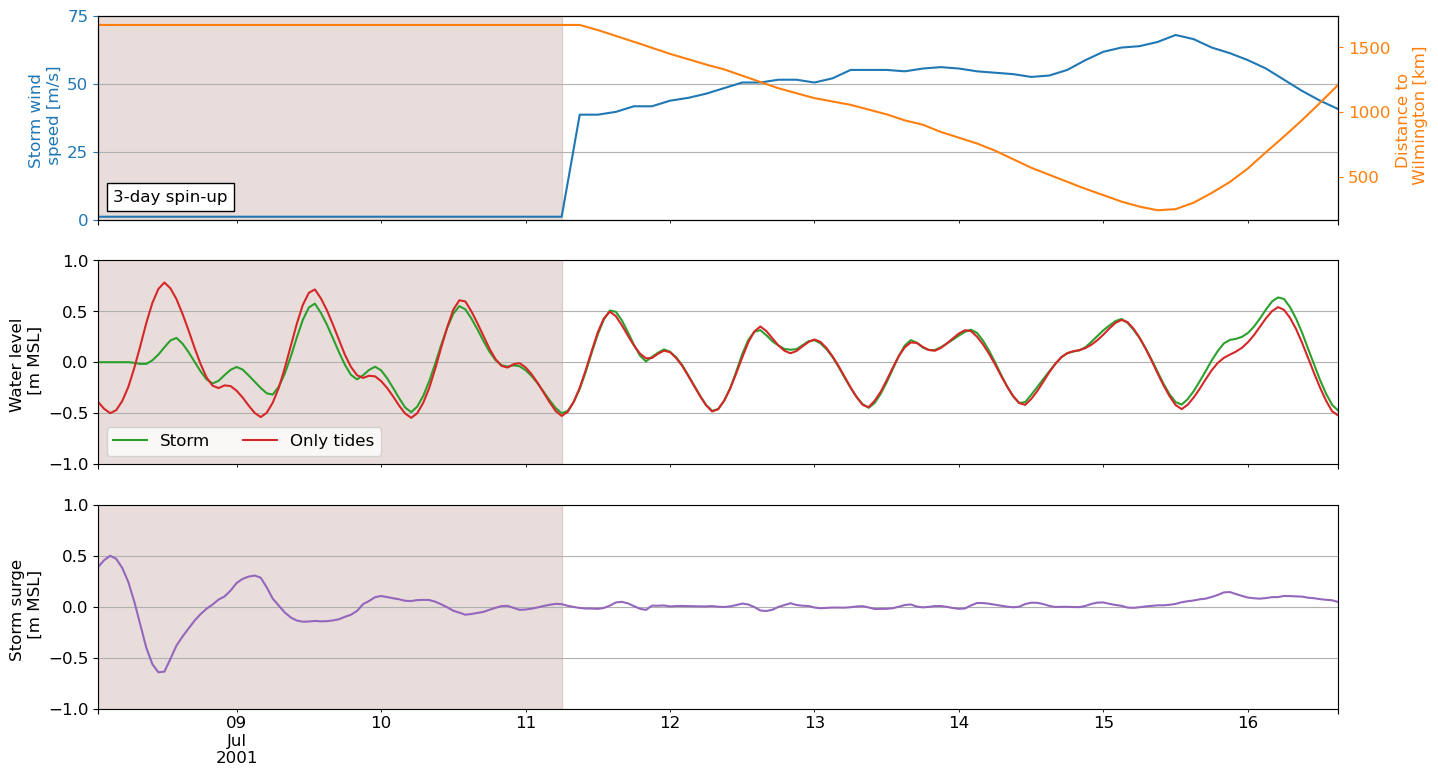

In [24]:
pointToPlot = 'pnt004'
f22 = readFort22(r'/media/tacuevas/Extreme SSD/batch02/0011/fort.22')
# f22 = readFort22(r'/media/tomas/SSD_tomas/thesis/wind/0011/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0011']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_pnt004'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                      'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                      'ws': f22_res['wind_speed'].values[1:],
                      'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]}, index = dfNOAAplot.index)


fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
dummy['tides'].plot(ax = ax[1], color = ccolors[3])
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4])

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[77], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+8, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 75])
ax[0].set_yticks(np.arange(0, 100, 25));
ax[0].right_ax.grid(False)
ax[0].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Wilmington [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[77], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 1.5, 0.5));
ax[1].set_ylim([-1.0, 1.0])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[1].grid(True)
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[77], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 1.5, 0.5));
ax[2].set_ylim([-1.0, 1.0])
ax[2].set_ylabel('Storm surge \n [m MSL]')
ax[2].grid(True)
anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
ax[1].legend(['Storm', 'Only tides'], loc = 'lower left', frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/waves_and_storm_surge/time_series_run0011.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/time_series_run0011.png', dpi = 300, bbox_inches = 'tight')

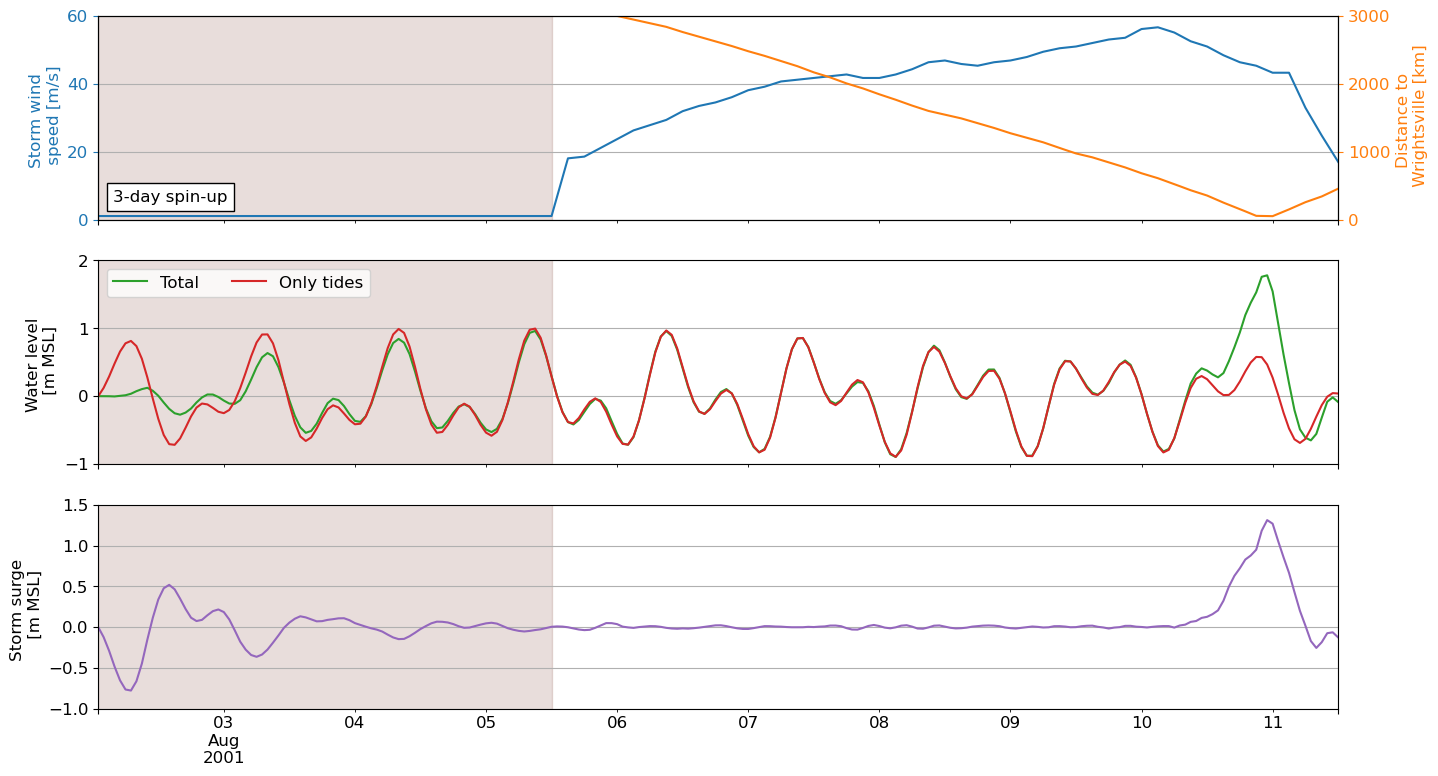

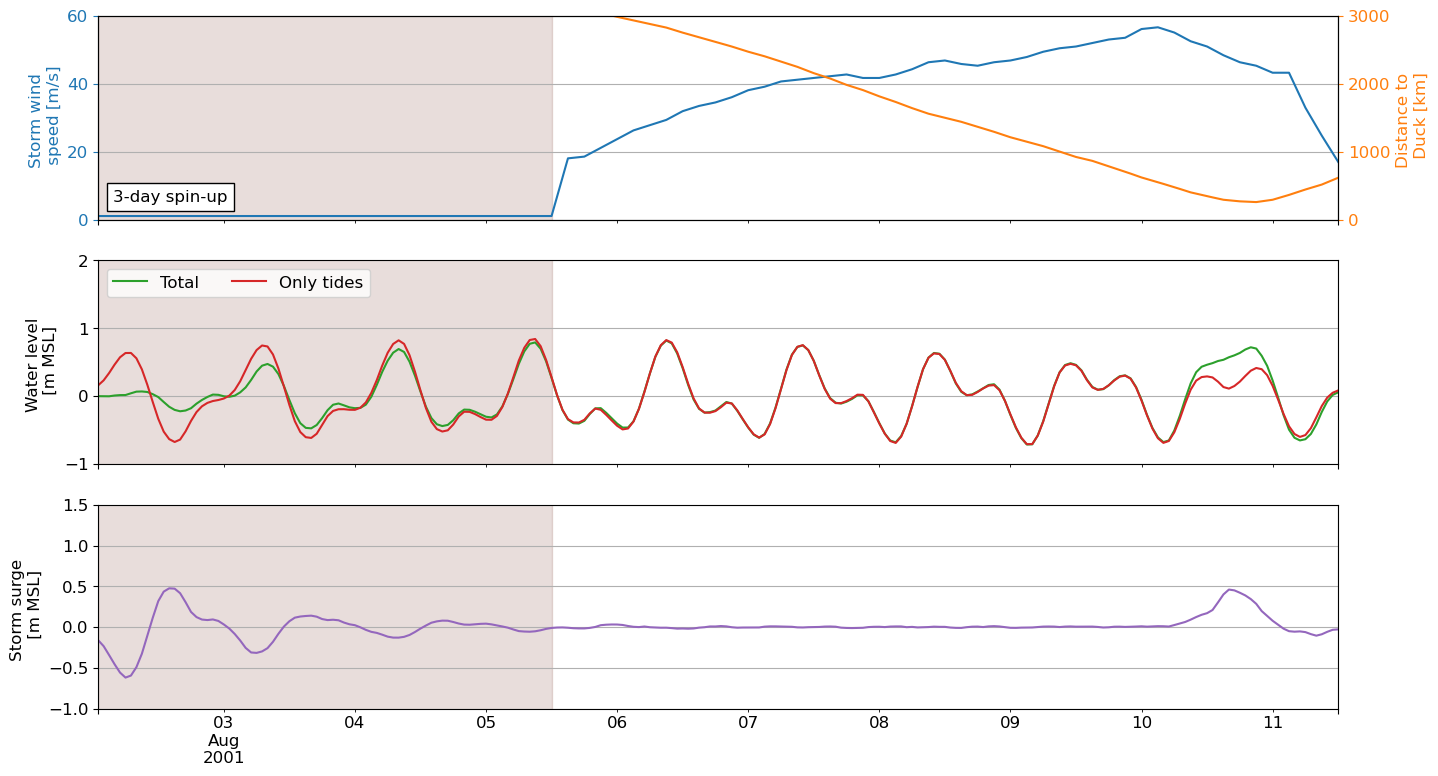

In [7]:
pointToPlot = 'pnt005'
f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0000']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_{pointToPlot}'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                    'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                    'ws': f22_res['wind_speed'].values[1:],
                    'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]},
                    # 'rmws': f22_res['rad_to_max_ws']}, 
                    index = dfNOAAplot.index)


# fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
# dummy['ws'].plot(ax = ax[0], color = ccolors[0])
# # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
# dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
# dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2], alpha = 0.2)
# dummy['tides'].plot(ax = ax[1], color = ccolors[3], alpha = 0.2)
# (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

# ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
# ax[0].set_ylim([0, 60])
# ax[0].set_yticks(np.arange(0, 80, 20));
# ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
# ax[0].right_ax.set_ylim([0, 3000])
# ax[0].right_ax.grid(False)
# ax[0].grid(True)
# ax[1].grid(True)
# ax[2].grid(True)
# # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
# ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
# ax[0].set_ylabel('Storm wind \n speed [m/s]')
# ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
# ax[1].set_yticks(np.arange(-1, 3, 1));
# ax[1].set_ylim([-1.0, 2.0])
# ax[1].set_ylabel('Water level \n [m MSL]')
# ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
# ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
# ax[2].set_ylim([-1.0, 1.5])
# ax[2].set_ylabel('Storm surge \n [m MSL]')
# anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
# ax[0].add_artist(anchored_text)
# ax[0].yaxis.label.set_color(ccolors[0])
# ax[0].tick_params(axis='y', colors=ccolors[0])
# ax[0].right_ax.yaxis.label.set_color(ccolors[1])
# ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
# ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_a.png', dpi = 300, bbox_inches = 'tight')

# fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
# dummy['ws'].plot(ax = ax[0], color = ccolors[0])
# # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
# dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
# dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
# dummy['tides'].plot(ax = ax[1], color = ccolors[3])
# (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

# ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
# ax[0].set_ylim([0, 60])
# ax[0].set_yticks(np.arange(0, 80, 20));
# ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
# ax[0].right_ax.set_ylim([0, 3000])
# ax[0].right_ax.grid(False)
# ax[0].grid(True)
# ax[1].grid(True)
# ax[2].grid(True)
# # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
# ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
# ax[0].set_ylabel('Storm wind \n speed [m/s]')
# ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
# ax[1].set_yticks(np.arange(-1, 3, 1));
# ax[1].set_ylim([-1.0, 2.0])
# ax[1].set_ylabel('Water level \n [m MSL]')
# ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
# ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
# ax[2].set_ylim([-1.0, 1.5])
# ax[2].set_ylabel('Storm surge \n [m MSL]')
# anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
# ax[0].add_artist(anchored_text)
# ax[0].yaxis.label.set_color(ccolors[0])
# ax[0].tick_params(axis='y', colors=ccolors[0])
# ax[0].right_ax.yaxis.label.set_color(ccolors[1])
# ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
# ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_b.png', dpi = 300, bbox_inches = 'tight')

fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
# dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
dummy['tides'].plot(ax = ax[1], color = ccolors[3])
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4])

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.arange(0, 80, 20));
ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
ax[0].right_ax.set_ylim([0, 3000])
ax[0].right_ax.grid(False)
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 3, 1));
ax[1].set_ylim([-1.0, 2.0])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
ax[2].set_ylim([-1.0, 1.5])
ax[2].set_ylabel('Storm surge \n [m MSL]')
anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
fig.savefig(r'../documents/thesis/time_series_run0000_wrightsville_c2.png', dpi = 300, bbox_inches = 'tight')

# fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
# dummy['ws'].plot(ax = ax[0], color = ccolors[0])
# # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
# dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
# dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
# dummy['tides'].plot(ax = ax[1], color = ccolors[3])
# (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

# ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
# ax[0].set_ylim([0, 60])
# ax[0].set_yticks(np.arange(0, 80, 20));
# ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
# ax[0].right_ax.set_ylim([0, 3000])
# ax[0].right_ax.grid(False)
# ax[0].grid(True)
# ax[1].grid(True)
# ax[2].grid(True)
# # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
# ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
# ax[0].set_ylabel('Storm wind \n speed [m/s]')
# ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
# ax[1].set_yticks(np.arange(-1, 3, 1));
# ax[1].set_ylim([-1.0, 2.0])
# ax[1].set_ylabel('Water level \n [m MSL]')
# ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
# ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
# ax[2].set_ylim([-1.0, 1.5])
# ax[2].set_ylabel('Storm surge \n [m MSL]')
# anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
# ax[0].add_artist(anchored_text)
# ax[0].yaxis.label.set_color(ccolors[0])
# ax[0].tick_params(axis='y', colors=ccolors[0])
# ax[0].right_ax.yaxis.label.set_color(ccolors[1])
# ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
# ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
# fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_b.png', dpi = 300, bbox_inches = 'tight')


pointToPlot = 'pnt000'
f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
dfNOAAplot = dctWaverLevelNOAA['0000']
dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
f22[f'dist_to_{pointToPlot}'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize('UTC')

dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                    'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                    'ws': f22_res['wind_speed'].values[1:],
                    'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]},
                    # 'rmws': f22_res['rad_to_max_ws']}, 
                    index = dfNOAAplot.index)

fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
dummy['ws'].plot(ax = ax[0], color = ccolors[0])
# dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
dummy['tides'].plot(ax = ax[1], color = ccolors[3])
(dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4])

ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.arange(0, 80, 20));
ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
ax[0].right_ax.set_ylim([0, 3000])
ax[0].right_ax.grid(False)
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
# ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
# ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
# ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
ax[0].right_ax.set_ylabel('Distance to \n Duck [km]')
ax[0].set_ylabel('Storm wind \n speed [m/s]')
ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[1].set_yticks(np.arange(-1, 3, 1));
ax[1].set_ylim([-1.0, 2.0])
ax[1].set_ylabel('Water level \n [m MSL]')
ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
ax[2].set_ylim([-1.0, 1.5])
ax[2].set_ylabel('Storm surge \n [m MSL]')
anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
ax[0].add_artist(anchored_text)
ax[0].yaxis.label.set_color(ccolors[0])
ax[0].tick_params(axis='y', colors=ccolors[0])
ax[0].right_ax.yaxis.label.set_color(ccolors[1])
ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
# ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
# ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
fig.savefig(r'../documents/thesis/time_series_run0000_duck2.png', dpi = 300, bbox_inches = 'tight')

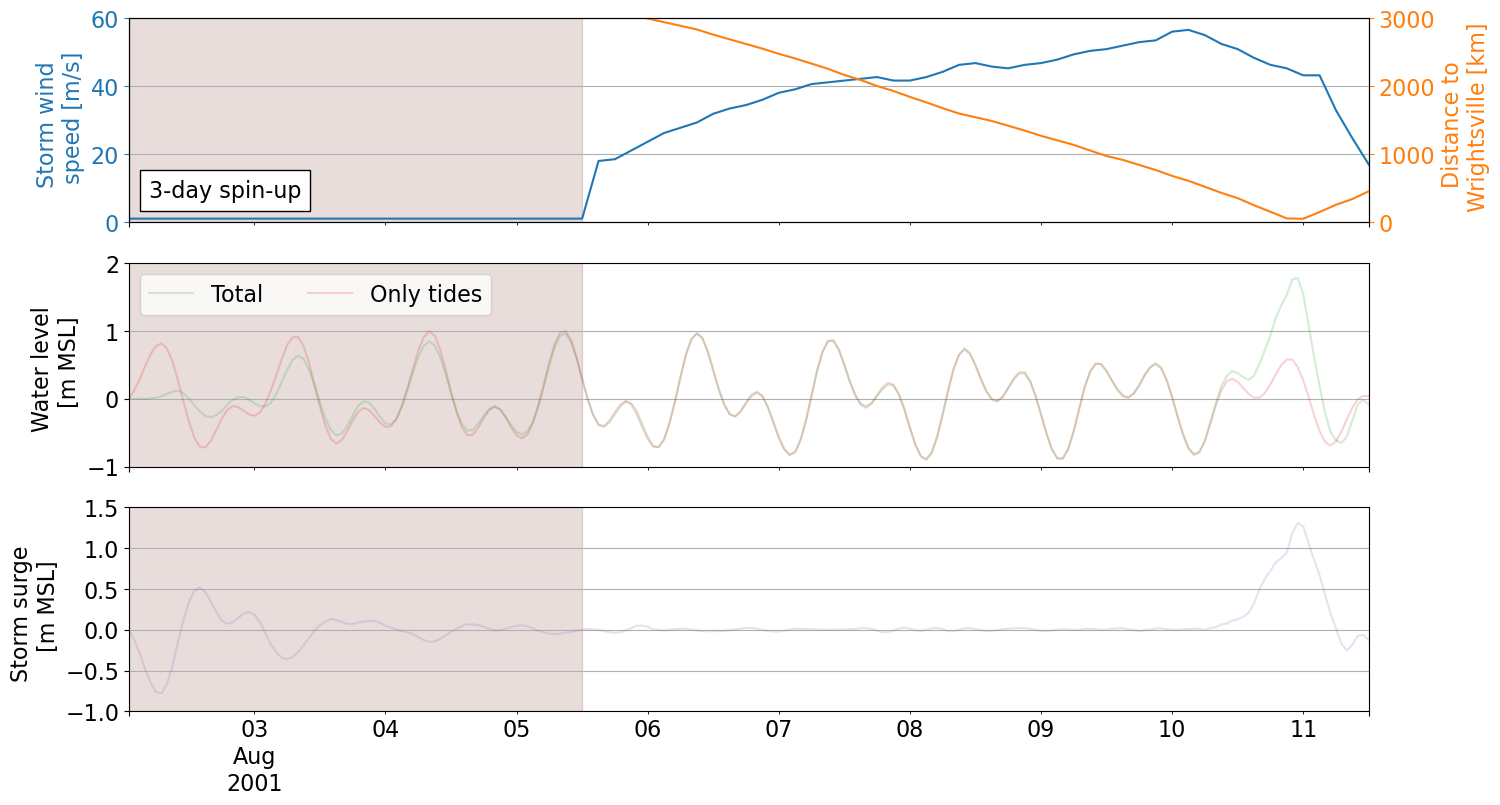

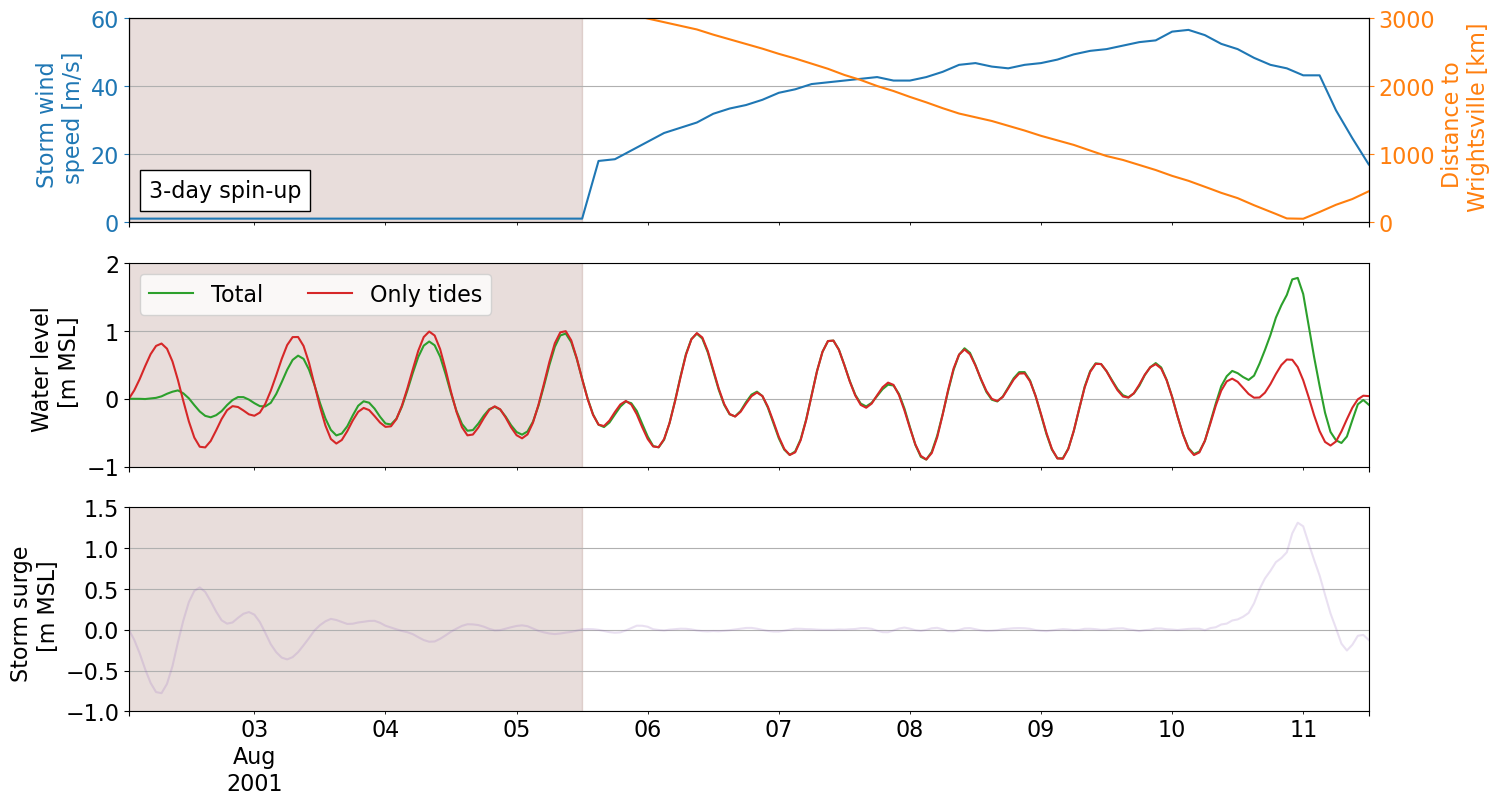

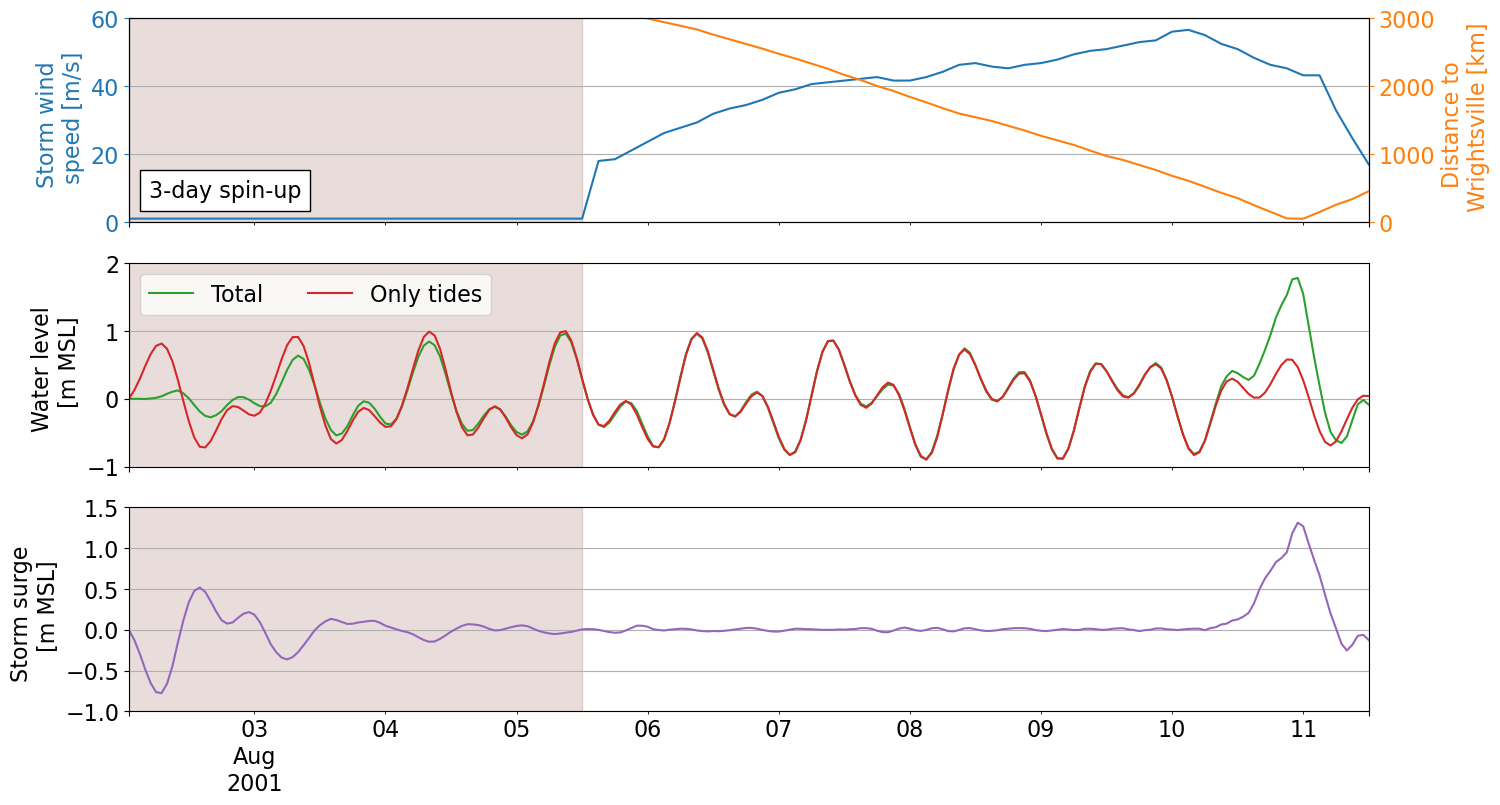

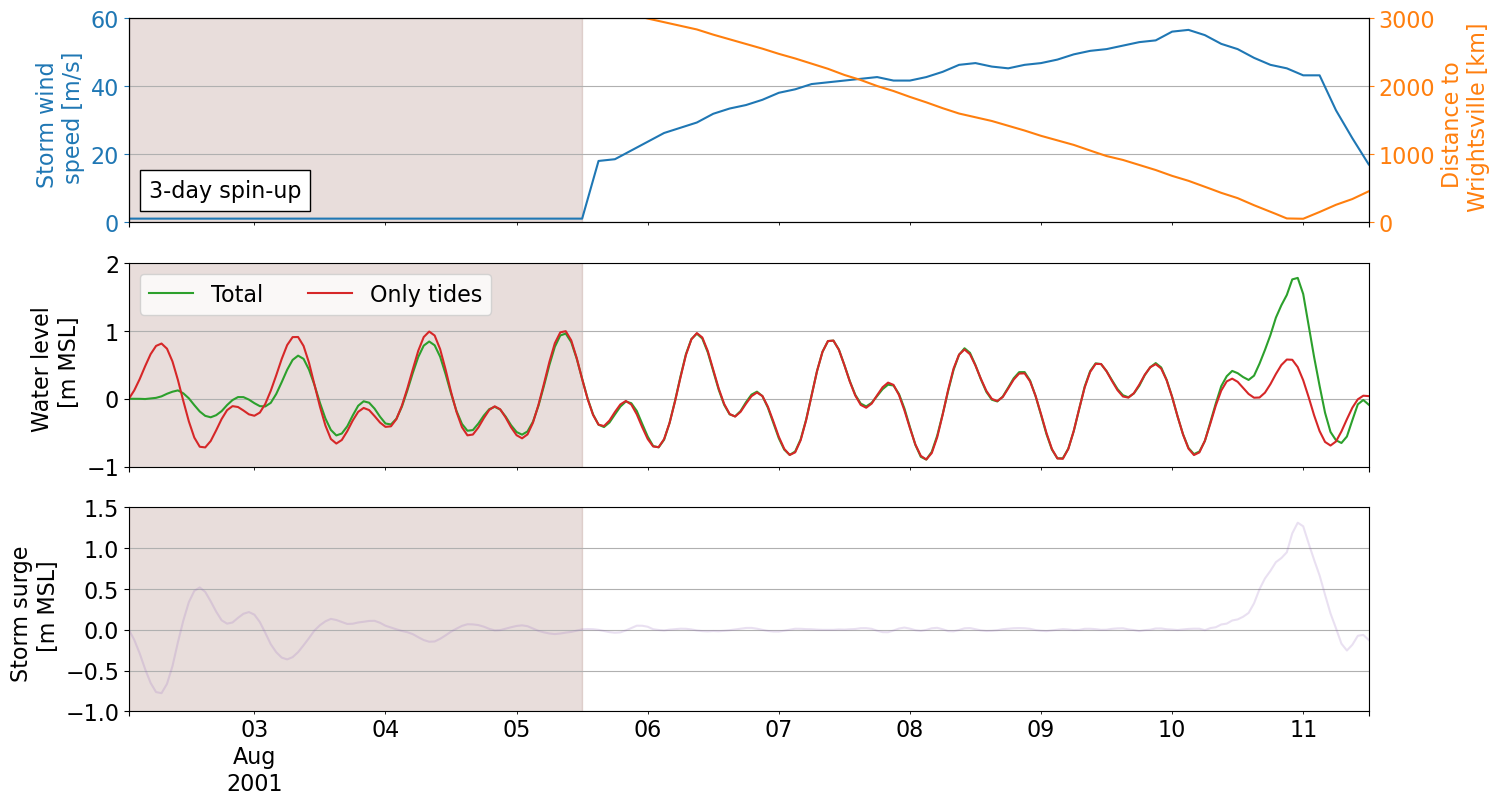

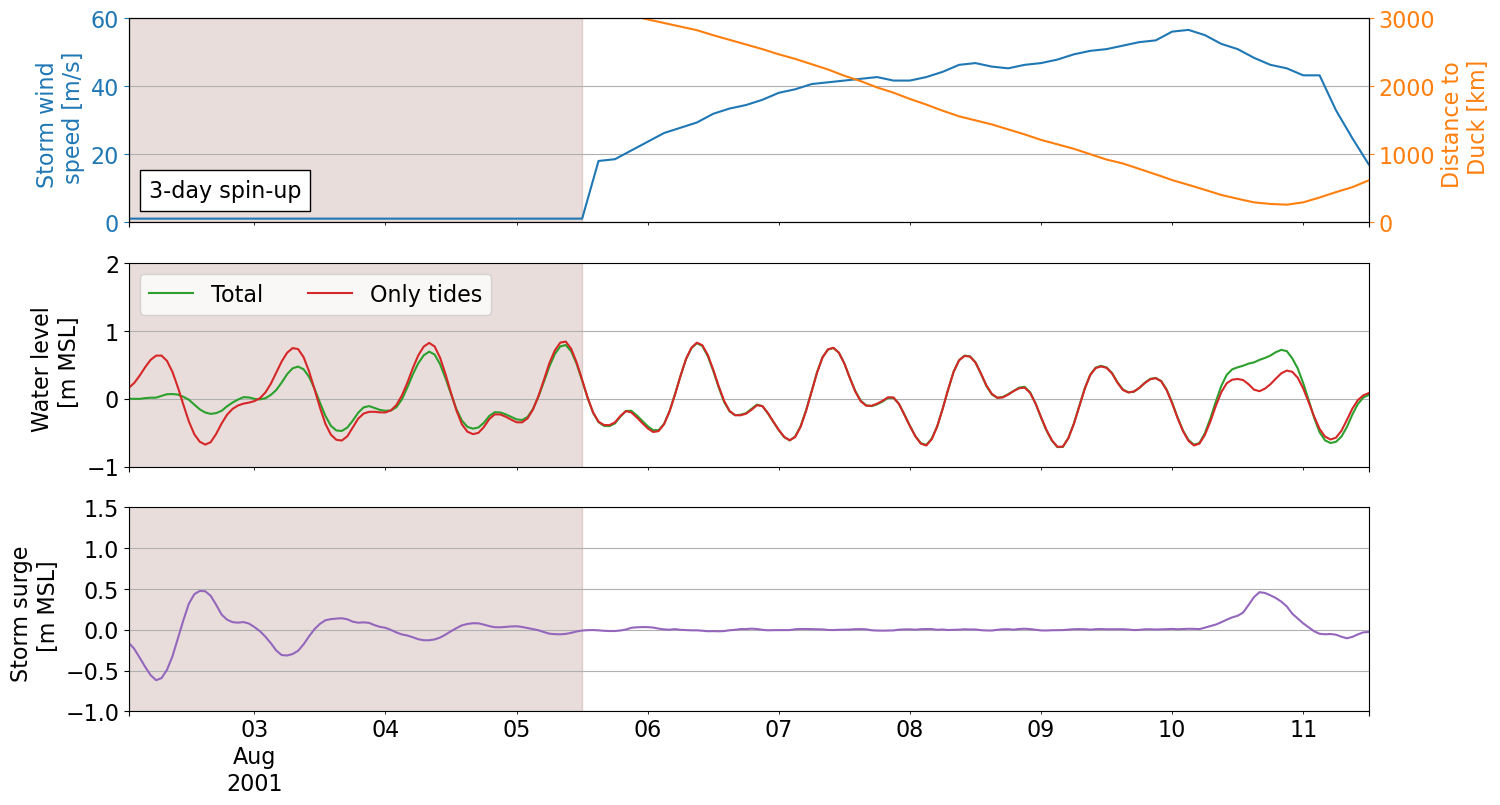

In [5]:
with plt.rc_context({'font.size': 16}):
    
    pointToPlot = 'pnt005'
    f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
    dfNOAAplot = dctWaverLevelNOAA['0000']
    dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
    f22[f'dist_to_{pointToPlot}'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
    f22_res = f22.resample('1H').interpolate('linear')
    f22_res.index = f22_res.index.tz_localize('UTC')

    dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                        'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                        'ws': f22_res['wind_speed'].values[1:],
                        'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]},
                        # 'rmws': f22_res['rad_to_max_ws']}, 
                        index = dfNOAAplot.index)


    fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
    dummy['ws'].plot(ax = ax[0], color = ccolors[0])
    # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
    dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
    dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2], alpha = 0.2)
    dummy['tides'].plot(ax = ax[1], color = ccolors[3], alpha = 0.2)
    (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

    ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
    ax[0].set_ylim([0, 60])
    ax[0].set_yticks(np.arange(0, 80, 20));
    ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
    ax[0].right_ax.set_ylim([0, 3000])
    ax[0].right_ax.grid(False)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
    # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
    # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
    ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
    ax[0].set_ylabel('Storm wind \n speed [m/s]')
    ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[1].set_yticks(np.arange(-1, 3, 1));
    ax[1].set_ylim([-1.0, 2.0])
    ax[1].set_ylabel('Water level \n [m MSL]')
    ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
    ax[2].set_ylim([-1.0, 1.5])
    ax[2].set_ylabel('Storm surge \n [m MSL]')
    anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
    ax[0].add_artist(anchored_text)
    ax[0].yaxis.label.set_color(ccolors[0])
    ax[0].tick_params(axis='y', colors=ccolors[0])
    ax[0].right_ax.yaxis.label.set_color(ccolors[1])
    ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
    # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
    ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
    # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
    fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_a.png', dpi = 300, bbox_inches = 'tight')

    fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
    dummy['ws'].plot(ax = ax[0], color = ccolors[0])
    # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
    dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
    dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
    dummy['tides'].plot(ax = ax[1], color = ccolors[3])
    (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

    ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
    ax[0].set_ylim([0, 60])
    ax[0].set_yticks(np.arange(0, 80, 20));
    ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
    ax[0].right_ax.set_ylim([0, 3000])
    ax[0].right_ax.grid(False)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
    # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
    # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
    ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
    ax[0].set_ylabel('Storm wind \n speed [m/s]')
    ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[1].set_yticks(np.arange(-1, 3, 1));
    ax[1].set_ylim([-1.0, 2.0])
    ax[1].set_ylabel('Water level \n [m MSL]')
    ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
    ax[2].set_ylim([-1.0, 1.5])
    ax[2].set_ylabel('Storm surge \n [m MSL]')
    anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
    ax[0].add_artist(anchored_text)
    ax[0].yaxis.label.set_color(ccolors[0])
    ax[0].tick_params(axis='y', colors=ccolors[0])
    ax[0].right_ax.yaxis.label.set_color(ccolors[1])
    ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
    # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
    ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
    # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
    fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_b.png', dpi = 300, bbox_inches = 'tight')

    fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
    dummy['ws'].plot(ax = ax[0], color = ccolors[0])
    # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
    dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
    dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
    dummy['tides'].plot(ax = ax[1], color = ccolors[3])
    (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4])

    ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
    ax[0].set_ylim([0, 60])
    ax[0].set_yticks(np.arange(0, 80, 20));
    ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
    ax[0].right_ax.set_ylim([0, 3000])
    ax[0].right_ax.grid(False)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
    # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
    # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
    ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
    ax[0].set_ylabel('Storm wind \n speed [m/s]')
    ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[1].set_yticks(np.arange(-1, 3, 1));
    ax[1].set_ylim([-1.0, 2.0])
    ax[1].set_ylabel('Water level \n [m MSL]')
    ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
    ax[2].set_ylim([-1.0, 1.5])
    ax[2].set_ylabel('Storm surge \n [m MSL]')
    anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
    ax[0].add_artist(anchored_text)
    ax[0].yaxis.label.set_color(ccolors[0])
    ax[0].tick_params(axis='y', colors=ccolors[0])
    ax[0].right_ax.yaxis.label.set_color(ccolors[1])
    ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
    # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
    ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
    # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
    fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_c.png', dpi = 300, bbox_inches = 'tight')

    fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
    dummy['ws'].plot(ax = ax[0], color = ccolors[0])
    # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
    dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
    dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
    dummy['tides'].plot(ax = ax[1], color = ccolors[3])
    (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4], alpha = 0.2)

    ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
    ax[0].set_ylim([0, 60])
    ax[0].set_yticks(np.arange(0, 80, 20));
    ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
    ax[0].right_ax.set_ylim([0, 3000])
    ax[0].right_ax.grid(False)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
    # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
    # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
    ax[0].right_ax.set_ylabel('Distance to \n Wrightsville [km]')
    ax[0].set_ylabel('Storm wind \n speed [m/s]')
    ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[1].set_yticks(np.arange(-1, 3, 1));
    ax[1].set_ylim([-1.0, 2.0])
    ax[1].set_ylabel('Water level \n [m MSL]')
    ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
    ax[2].set_ylim([-1.0, 1.5])
    ax[2].set_ylabel('Storm surge \n [m MSL]')
    anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
    ax[0].add_artist(anchored_text)
    ax[0].yaxis.label.set_color(ccolors[0])
    ax[0].tick_params(axis='y', colors=ccolors[0])
    ax[0].right_ax.yaxis.label.set_color(ccolors[1])
    ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
    # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
    ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
    # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
    fig.savefig(r'../documents/defense/time_series_run0000_wrightsville_b.png', dpi = 300, bbox_inches = 'tight')

    
    pointToPlot = 'pnt000'
    f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
    dfNOAAplot = dctWaverLevelNOAA['0000']
    dfBASEplot = dfWaverLevelNOAAbase.loc[dfWaverLevelNOAAbase.index.isin(dfNOAAplot.index), :]
    f22[f'dist_to_{pointToPlot}'] = [geopy.distance.geodesic((ys[int(pointToPlot[-1])], xs[int(pointToPlot[-1])]), (yi, xi)).km for yi, xi in zip(f22['lat'], f22['lon'])]
    f22_res = f22.resample('1H').interpolate('linear')
    f22_res.index = f22_res.index.tz_localize('UTC')

    dummy = pd.DataFrame({'stormSurge': dfNOAAplot[f'zeta_{pointToPlot}'].values,
                        'tides': dfBASEplot[f'zeta_{pointToPlot}'].values,
                        'ws': f22_res['wind_speed'].values[1:],
                        'dist': f22_res[f'dist_to_{pointToPlot}'].values[1:]},
                        # 'rmws': f22_res['rad_to_max_ws']}, 
                        index = dfNOAAplot.index)
    
    fig, ax = plt.subplots(figsize = (16, 9), nrows = 3, sharex = True)
    dummy['ws'].plot(ax = ax[0], color = ccolors[0])
    # dummy['rmws'].plot(ax = ax[0], color = ccolors[5])
    dummy['dist'].plot(ax = ax[0], secondary_y = True, color = ccolors[1])
    dummy['stormSurge'].plot(ax = ax[1], color = ccolors[2])
    dummy['tides'].plot(ax = ax[1], color = ccolors[3])
    (dummy['stormSurge'] - dummy['tides']).plot(ax = ax[2], color = ccolors[4])

    ax[0].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = dummy['ws'].min()-2, y2 = dummy['ws'].max()+5, color = ccolors[5], alpha = 0.2)
    ax[0].set_ylim([0, 60])
    ax[0].set_yticks(np.arange(0, 80, 20));
    ax[0].right_ax.set_yticks(np.arange(0, 4000, 1000));
    ax[0].right_ax.set_ylim([0, 3000])
    ax[0].right_ax.grid(False)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].right_ax.get_yticks())))
    # ax[0].right_ax.set_yticklabels(['-1000', '', '', '1500'])
    # ax[0].right_ax.set_yticks(np.arange(-1000, 5500, 1500));
    ax[0].right_ax.set_ylabel('Distance to \n Duck [km]')
    ax[0].set_ylabel('Storm wind \n speed [m/s]')
    ax[1].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 2.05, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[1].set_yticks(np.arange(-1, 3, 1));
    ax[1].set_ylim([-1.0, 2.0])
    ax[1].set_ylabel('Water level \n [m MSL]')
    ax[2].fill_between(x = pd.date_range(dummy.index[0], dummy.index[83], freq = '1H'), y1 = 1.55, y2 = -1.1, color = ccolors[5], alpha = 0.2)
    ax[2].set_yticks(np.arange(-1, 2.0, 0.5));
    ax[2].set_ylim([-1.0, 1.5])
    ax[2].set_ylabel('Storm surge \n [m MSL]')
    anchored_text = AnchoredText("3-day spin-up", loc = 'lower left')
    ax[0].add_artist(anchored_text)
    ax[0].yaxis.label.set_color(ccolors[0])
    ax[0].tick_params(axis='y', colors=ccolors[0])
    ax[0].right_ax.yaxis.label.set_color(ccolors[1])
    ax[0].right_ax.tick_params(axis='y', colors=ccolors[1])
    # ax[0].right_ax.legend(['Right y-axis'], loc = 'center left', frameon = True, bbox_to_anchor=(0, 0.67))
    ax[1].legend(['Total', 'Only tides'], loc = 2, frameon = True, ncol = 2)
    # ax[2].legend(['Storm surge'], loc = 2, frameon = True, ncol = 1)
    fig.savefig(r'../documents/defense/time_series_run0000_duck.png', dpi = 300, bbox_inches = 'tight')

In [2]:
nc0 = netcdf.Dataset(r'../models/adcirc/concorde/batch02/_results/0000/fort.63.nc')
nc1 = netcdf.Dataset(r'../models/adcirc/concorde/batch02/_results/0000/fort.74.nc')
nc2 = netcdf.Dataset(r'../models/adcirc/concorde/batch02/_results/0000/maxele.63.nc')
var = 'zeta'
levels = np.arange(-4, 4.5, 0.5)

In [3]:
dates = getDates(r'../models/adcirc/concorde/batch02/_results/0000/fort.63.nc')
dates.index = dates['dates']
dates.index = dates.index.tz_localize(None)

In [4]:
f22 = readFort22(r'../models/adcirc/concorde/batch02/_results/0000/fort.22')
f22_res = f22.resample('1H').interpolate('linear')
f22_res.index = f22_res.index.tz_localize(None)

In [5]:
f22_res['cat'] = [ssScale(x) for x in f22_res['wind_speed']]

In [6]:
ys = [36.183, 35.795, 35.209, 34.717, 34.227, 34.213]
xs = [-75.745, -75.548, -75.704, -76.67, -77.953, -77.787]
names = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

In [8]:
with plt.rc_context({'font.size': 16}):

    cmap_cat = cmocean.cm.speed
    norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap_cat.N)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    cbs = 0.64

    fig, ax = plt.subplots(figsize = (16, 9), ncols = 2, nrows = 1,
                       subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    ts0 = 202
    plot2D(nc0, var, levels, ts = ts0, cbar = False, cmap = cmocean.cm.balance, ax = ax[0], 
        background_map = True, ncvec = nc1, dxvec = 1, dyvec = 1, vecsc = 500, 
        annotate_date = False)
    ax[0].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
    c = cmap_cat(int(f22_res.iloc[ts0, -1])/5)
    ax[0].scatter([f22_res.iloc[ts0, 0]], [f22_res.iloc[ts0, 1]], marker = tcmarkers.HU,
                    color = c, s = 50)
    # ax[0].annotate(f"Cat: {int(f22_res.iloc[ts0, -1])}", xy = (0, 0.92), 
    #                xycoords='axes fraction', ha='left', va="center", fontsize=10)
    ax[0].text(0.03, 0.06, '12 hrs before landfall', transform=ax[0].transAxes, fontsize=16,
            verticalalignment='top', bbox=props)

    plot2D(nc0, var, levels, ts = ts0, cbar = True, cmap = cmocean.cm.balance, ax = ax[1], 
        background_map = True, ncvec = nc1, dxvec = 0.25, dyvec = 0.25, vecsc = 800,
        xlims = [-78.5, -75], ylims = [33.75, 36.75], fig = fig, cb_shrink = cbs, 
        cb_label='Total water level [m MSL]', annotate_date = False)
    ax[1].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
    c = cmap_cat(int(f22_res.iloc[ts0, -1])/5)
    ax[1].scatter([f22_res.iloc[ts0, 0]], [f22_res.iloc[ts0, 1]], marker = tcmarkers.HU,
                    color = c, s = 50)
    # ax[1].annotate(f"Cat: {int(f22_res.iloc[ts0, -1])}", xy = (0, 0.92), 
    #                xycoords='axes fraction', ha='left', va="center", fontsize=10)
    ax[1].scatter([xs[0], xs[-1]], [ys[0], ys[-1]], c = 'k', s = 30, marker = 'x')
    ax[1].text(xs[0], ys[0], 'Duck', size = 10, color = 'k')
    ax[1].text(xs[-1], ys[-1], 'Wrightsville', size = 10, color = 'k')

    fig = ax[0].get_figure()
    cax = fig.add_axes([0.25, 0.12, 0.5, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap_cat, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'S - S Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))
    fig.savefig(r'../documents/defense/2D_map_storm0000_a.png', dpi = 300, 
                bbox_inches = 'tight')
    
    fig, ax = plt.subplots(figsize = (16, 9), ncols = 2, nrows = 1,
                       subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
    ts0 = 214
    plot2D(nc0, var, levels, ts = ts0, cbar = False, cmap = cmocean.cm.balance, ax = ax[0], 
        background_map = True, ncvec = nc1, dxvec = 1, dyvec = 1, vecsc = 500, 
        annotate_date = False)
    ax[0].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
    c = cmap_cat(int(f22_res.iloc[ts0, -1])/5)
    ax[0].scatter([f22_res.iloc[ts0, 0]], [f22_res.iloc[ts0, 1]], marker = tcmarkers.HU,
                    color = c, s = 50)
    # ax[0].annotate(f"Cat: {int(f22_res.iloc[ts0, -1])}", xy = (0, 0.92), 
    #                xycoords='axes fraction', ha='left', va="center", fontsize=10)
    ax[0].text(0.03, 0.06, 'Landfall', transform=ax[0].transAxes, fontsize=16,
            verticalalignment='top', bbox=props)

    plot2D(nc0, var, levels, ts = ts0, cbar = True, cmap = cmocean.cm.balance, ax = ax[1], 
        background_map = True, ncvec = nc1, dxvec = 0.25, dyvec = 0.25, vecsc = 800,
        xlims = [-78.5, -75], ylims = [33.75, 36.75], fig = fig, cb_shrink = cbs, 
        cb_label='Total water level [m MSL]', annotate_date = False)
    ax[1].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
    c = cmap_cat(int(f22_res.iloc[ts0, -1])/5)
    ax[1].scatter([f22_res.iloc[ts0, 0]], [f22_res.iloc[ts0, 1]], marker = tcmarkers.HU,
                    color = c, s = 50)
    # ax[1].annotate(f"Cat: {int(f22_res.iloc[ts0, -1])}", xy = (0, 0.92), 
    #                xycoords='axes fraction', ha='left', va="center", fontsize=10)
    ax[1].scatter([xs[0], xs[-1]], [ys[0], ys[-1]], c = 'k', s = 30, marker = 'x')
    ax[1].text(xs[0], ys[0], 'Duck', size = 10, color = 'k')
    ax[1].text(xs[-1], ys[-1], 'Wrightsville', size = 10, color = 'k')

    fig = ax[0].get_figure()
    cax = fig.add_axes([0.25, 0.12, 0.5, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap_cat, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'S - S Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))
    fig.savefig(r'../documents/defense/2D_map_storm0000_b.png', dpi = 300, 
                bbox_inches = 'tight')
    
    fig, ax = plt.subplots(figsize = (16, 9), ncols = 2, nrows = 1,
                       subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)    
    plot2D(nc2, 'zeta_max', np.arange(0, 3.25, 0.25), cbar = False, cmap = cmocean.cm.amp, 
           ax = ax[0], background_map = True)
    ax[0].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
    ax[0].scatter(f22_res['lon'], f22_res['lat'], c = f22_res['cat'], cmap = cmap_cat, 
                  norm = norm, s = 10)
    ax[0].text(0.03, 0.06, 'Peak total water level', transform=ax[0].transAxes, fontsize=16,
            verticalalignment='top', bbox=props)

    plot2D(nc2, 'zeta_max', np.arange(0, 4.25, 0.25), cbar = True, cmap = cmocean.cm.amp, 
           ax = ax[1], background_map = True, xlims = [-78.5, -75], ylims = [33.75, 36.75], 
           fig = fig, cb_shrink = cbs, cb_label='Peak total water level [m MSL]')
    ax[1].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
    ax[1].scatter(f22_res['lon'], f22_res['lat'], c = f22_res['cat'], cmap = cmap_cat, 
                  norm = norm, s = 100)
    ax[1].scatter([xs[0], xs[-1]], [ys[0], ys[-1]], c = 'k', s = 30, marker = 'x')
    ax[1].text(xs[0], ys[0], 'Duck', size = 10, color = 'k')
    ax[1].text(xs[-1], ys[-1], 'Wrightsville', size = 10, color = 'k')

    fig = ax[0].get_figure()
    cax = fig.add_axes([0.25, 0.12, 0.5, 0.02])
    sm = plt.cm.ScalarMappable(cmap = cmap_cat, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'S - S Scale', orientation = 'horizontal')
    loc = np.arange(0, 6, 1) + .5
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 6, 1))
    fig.savefig(r'../documents/defense/2D_map_storm0000_c.png', dpi = 300, 
                bbox_inches = 'tight')

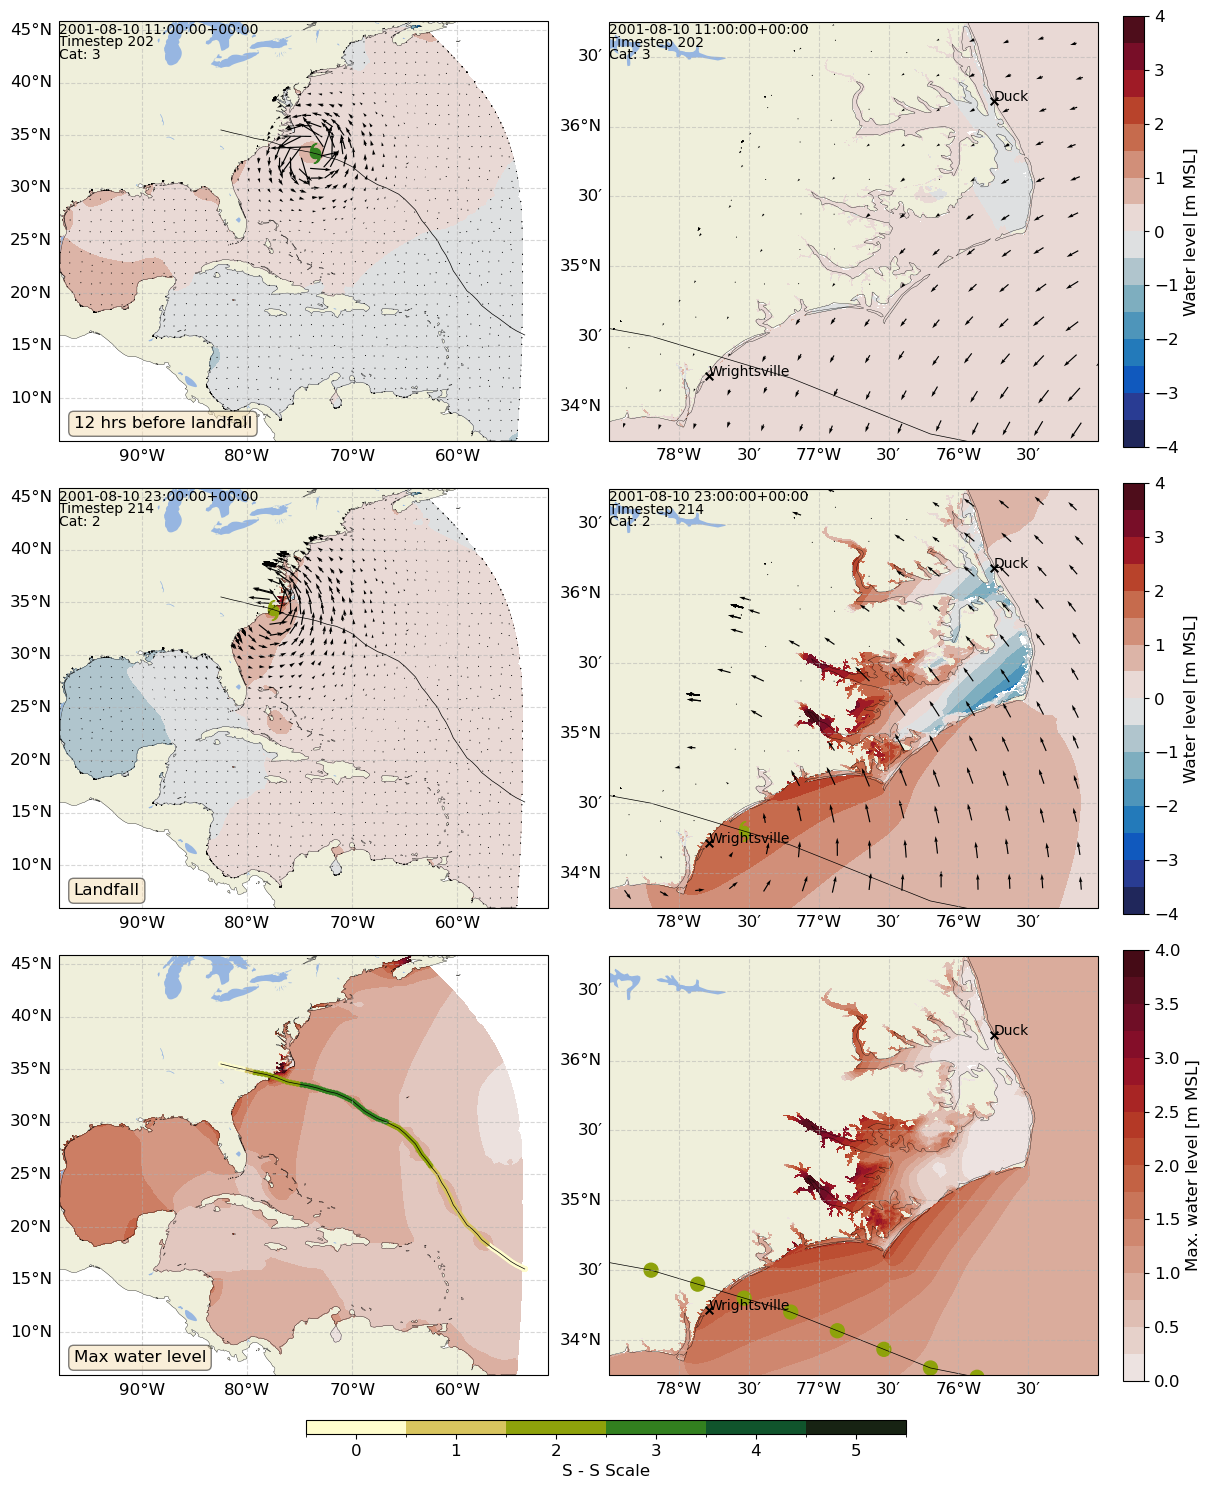

In [11]:
cmap_cat = cmocean.cm.speed
norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap_cat.N)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
cbs = 1

fig, ax = plt.subplots(figsize = (12, 14), ncols = 2, nrows = 3,
                       subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
ts0 = 202
plot2D(nc0, var, levels, ts = ts0, cbar = False, cmap = cmocean.cm.balance, ax = ax[0, 0], 
       background_map = True, ncvec = nc1, dxvec = 1, dyvec = 1, vecsc = 500)
ax[0, 0].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
c = cmap_cat(int(f22_res.iloc[ts0, -1])/5)
ax[0, 0].scatter([f22_res.iloc[ts0, 0]], [f22_res.iloc[ts0, 1]], marker = tcmarkers.HU,
                 color = c, s = 50)
ax[0, 0].annotate(f"Cat: {int(f22_res.iloc[ts0, -1])}", xy = (0, 0.92), xycoords='axes fraction',
              ha='left', va="center", fontsize=10)
ax[0, 0].text(0.03, 0.06, '12 hrs before landfall', transform=ax[0, 0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plot2D(nc0, var, levels, ts = ts0, cbar = True, cmap = cmocean.cm.balance, ax = ax[0, 1], 
       background_map = True, ncvec = nc1, dxvec = 0.25, dyvec = 0.25, vecsc = 800,
       xlims = [-78.5, -75], ylims = [33.75, 36.75], fig = fig, cb_shrink = cbs, cb_label='Water level [m MSL]')
ax[0, 1].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
c = cmap_cat(int(f22_res.iloc[ts0, -1])/5)
ax[0, 1].scatter([f22_res.iloc[ts0, 0]], [f22_res.iloc[ts0, 1]], marker = tcmarkers.HU,
                 color = c, s = 50)
ax[0, 1].annotate(f"Cat: {int(f22_res.iloc[ts0, -1])}", xy = (0, 0.92), xycoords='axes fraction',
              ha='left', va="center", fontsize=10)
ax[0, 1].scatter([xs[0], xs[-1]], [ys[0], ys[-1]], c = 'k', s = 30, marker = 'x')
ax[0, 1].text(xs[0], ys[0], 'Duck', size = 10, color = 'k')
ax[0, 1].text(xs[-1], ys[-1], 'Wrightsville', size = 10, color = 'k')

ts1 = 214
plot2D(nc0, var, levels, ts = ts1, cbar = False, cmap = cmocean.cm.balance, ax = ax[1, 0], 
       background_map = True, ncvec = nc1, dxvec = 1, dyvec = 1, vecsc = 500)
ax[1, 0].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
c = cmap_cat(int(f22_res.iloc[ts1, -1])/5)
ax[1, 0].scatter([f22_res.iloc[ts1, 0]], [f22_res.iloc[ts1, 1]], marker = tcmarkers.HU,
                 color = c, s = 50)
ax[1, 0].annotate(f"Cat: {int(f22_res.iloc[ts1, -1])}", xy = (0, 0.92), xycoords='axes fraction',
              ha='left', va="center", fontsize=10)
ax[1, 0].text(0.03, 0.06, 'Landfall', transform=ax[1, 0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plot2D(nc0, var, levels, ts = ts1, cbar = True, cmap = cmocean.cm.balance, ax = ax[1, 1], 
       background_map = True, ncvec = nc1, dxvec = 0.25, dyvec = 0.25, vecsc = 800,
        xlims = [-78.5, -75], ylims = [33.75, 36.75], fig = fig, cb_shrink = cbs, cb_label='Water level [m MSL]')
ax[1, 1].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
c = cmap_cat(int(f22_res.iloc[ts1, -1])/5)
ax[1, 1].scatter([f22_res.iloc[ts1, 0]], [f22_res.iloc[ts1, 1]], marker = tcmarkers.HU,
                 color = c, s = 50)
ax[1, 1].annotate(f"Cat: {int(f22_res.iloc[ts1, -1])}", xy = (0, 0.92), xycoords='axes fraction',
              ha='left', va="center", fontsize=10)
ax[1, 1].scatter([xs[0], xs[-1]], [ys[0], ys[-1]], c = 'k', s = 30, marker = 'x')
ax[1, 1].text(xs[0], ys[0], 'Duck', size = 10, color = 'k')
ax[1, 1].text(xs[-1], ys[-1], 'Wrightsville', size = 10, color = 'k')

plot2D(nc2, 'zeta_max', np.arange(0, 3.25, 0.25), cbar = False, cmap = cmocean.cm.amp, ax = ax[2, 0], 
       background_map = True)
ax[2, 0].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
ax[2, 0].scatter(f22_res['lon'], f22_res['lat'], c = f22_res['cat'], cmap = cmap_cat, norm = norm, 
                 s = 10)
ax[2, 0].text(0.03, 0.06, 'Max water level', transform=ax[2, 0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plot2D(nc2, 'zeta_max', np.arange(0, 4.25, 0.25), cbar = True, cmap = cmocean.cm.amp, ax = ax[2, 1], 
       background_map = True, xlims = [-78.5, -75], ylims = [33.75, 36.75], fig = fig, cb_shrink = cbs, cb_label='Max. water level [m MSL]')
ax[2, 1].plot(f22_res['lon'], f22_res['lat'], color = 'k', lw = 0.5)
ax[2, 1].scatter(f22_res['lon'], f22_res['lat'], c = f22_res['cat'], cmap = cmap_cat, norm = norm, 
                 s = 100)
ax[2, 1].scatter([xs[0], xs[-1]], [ys[0], ys[-1]], c = 'k', s = 30, marker = 'x')
ax[2, 1].text(xs[0], ys[0], 'Duck', size = 10, color = 'k')
ax[2, 1].text(xs[-1], ys[-1], 'Wrightsville', size = 10, color = 'k')

fig = ax[2, 0].get_figure()
cax = fig.add_axes([0.25, -0.02, 0.5, 0.01])
sm = plt.cm.ScalarMappable(cmap = cmap_cat, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'S - S Scale', orientation = 'horizontal')
loc = np.arange(0, 6, 1) + .5
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 6, 1))

fig.savefig(r'..//documents/thesis/2D_map_storm0000.png', dpi = 300, bbox_inches = 'tight')

In [79]:
f22_res.describe().T

count        mean        std         min         25%  \
lon            229.0  -60.870306   8.452444  -82.500000  -66.200000   
lat            229.0   22.474236   7.150689   16.000000   16.000000   
wind_speed     229.0   26.023311  21.057334    1.028891    1.028891   
pressure       229.0  983.004367  26.373248  939.000000  959.666667   
rad_to_max_ws  229.0   43.921397  11.524093   28.000000   37.000000   
cat            229.0    0.943231   1.124414    0.000000    0.000000   

                      50%          75%         max  
lon            -57.700000   -53.600000   -53.60000  
lat             18.800000    29.700000    35.50000  
wind_speed      31.895629    45.614179    56.58902  
pressure       979.000000  1013.000000  1013.00000  
rad_to_max_ws   46.000000    46.000000    93.00000  
cat              0.000000     2.000000     3.00000

In [27]:
listMaxElevs = sorted(get_list(r'/media/tacuevas/Extreme SSD/batch02', ends = 'maxele.63.nc', not_contains = 'base'))
dfMaxElevs = []
for im63, m63 in tqdm(enumerate(listMaxElevs)):
    r = os.path.dirname(m63).split('/')[-1]
    if r in dfMaxNC_corr.index:
        nc = netcdf.Dataset(m63, 'r')
        aux = nc['zeta_max'][:].data
        if im63 == 0:
            x = nc['x'][:].data
            y = nc['y'][:].data
            z = nc['zeta_max'][:].data
            z[z < -99000] = np.nan
            dfMaxElevs = pd.DataFrame(index = range(len(x)), columns = ['x', 'y', '0000'], data = np.array((x, y, z)).T)
        # z[z < -99000] = np.nan
        # dfMaxElevs.append(z)
            # dfMaxElevs = pd.DataFrame(index = range(len(x)), columns = ['x', 'y', '0000'], data = np.array((x, y, z)).T)
        else:
            
            z = nc['zeta_max'][:].data
            z[z < -99000] = np.nan
            dfMaxElevs[r] = z
# dfMaxElevs.to_pickle(r'../models/adcirc/concorde/batch02/_postprocessing/all_maxEle63_below10.pkl')

1813it [04:42,  6.42it/s]


In [ ]:
# dfMaxElev = pd.read_pickle(r'../models/adcirc/concorde/batch02/_postprocessing/all_maxEle63_below10.pkl')

In [ ]:
# sabv5 = gpd.read_file(r'/mnt/drive1/Insyncs/NCSU/thesis/gis/gpkg/SABv5.gpkg')
# sabv5_nodes = readNodes_fort14(r'../models/adcirc/concorde/batch02/01/_template/fort.14')
# mask = gpd.GeoDataFrame(geometry = [Polygon([(-79, 37.5), (-79, 33), (-74.5, 33), (-74.5, 37.5), (-79, 37.5)])],
#                         crs = 4326)
# newMeshTri, meshSub, dfNodesInside = subsetMeshGdf2(sabv5, sabv5_nodes, mask, out=False)

In [3]:
# meshSub.to_file(r'/mnt/drive1/Insyncs/NCSU/thesis/gis/gpkg/SABv5_subsetBoxNC.gpkg', driver = 'GPKG')
# dfNodesInside.to_csv(r'/mnt/drive1/Insyncs/NCSU/thesis/gis/csv/nodesSABv5_subsetBoxNC.csv')

meshSub = gpd.read_file(r'../gis/gpkg/SABv5_subsetBoxNC.gpkg')
dfNodesInside = pd.read_csv(r'../gis/csv/nodesSABv5_subsetBoxNC.csv', index_col = 0)

In [4]:
# dfMaxElev = dfMaxElev.loc[dfMaxElev.index.isin(dfNodesInside['orgIndex'].iloc[:1000]), :]
dfMaxElev = pd.read_pickle(r'../models/adcirc/concorde/batch02/_postprocessing/all_maxEle63_below10_subsetBoxNC.pkl')

In [30]:
dfMaxElev.head()

x          y      0000      0001      0002      0003  \
339485 -76.579718  34.729140  1.303112       NaN       NaN       NaN   
339486 -76.579065  34.728902       NaN       NaN       NaN       NaN   
339487 -76.579711  34.730547  1.320977       NaN       NaN       NaN   
339488 -76.579731  34.729844  1.315112       NaN       NaN       NaN   
339489 -76.580418  34.729447  1.319840  0.597021  0.614101  0.624637   

            0004      0005  0006      0007  ...      1804      1805      1806  \
339485       NaN       NaN   NaN       NaN  ...       NaN       NaN       NaN   
339486       NaN       NaN   NaN       NaN  ...       NaN       NaN       NaN   
339487       NaN       NaN   NaN       NaN  ...       NaN       NaN       NaN   
339488       NaN       NaN   NaN       NaN  ...       NaN       NaN       NaN   
339489  0.521029  0.440356   NaN  0.694562  ...  0.752068  0.433547  0.779865   

            1807      1808     1809      1810      1811      1812      1813  
339485  1.116891       NaN      NaN       NaN       NaN       NaN       NaN  
339486       NaN       NaN      NaN       NaN       NaN       NaN       NaN  
339487       NaN       NaN      NaN       NaN       NaN       NaN       NaN  
339488       NaN       NaN      NaN       NaN       NaN       NaN       NaN  
339489  1.122240  0.769004  0.70144  0.582072  0.640448  0.446958  0.492657  

[5 rows x 1795 columns]

In [5]:
# maxOfMax = dfMaxElev.iloc[:, 2:].max(axis = 1)
maxOfMax = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/maxOfMax_all_maxEle63_below10_subsetBoxNC.csv', index_col = 0)
# per75OfMax = dfMaxElev.iloc[:, 2:].quantile(0.75, axis = 1)
per75OfMax = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/per75OfMax_all_maxEle63_below10_subsetBoxNC.csv', index_col = 0)
# meanOfMax = dfMaxElev.iloc[:, 2:].mean(axis = 1)
meanOfMax = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/meanOfMax_all_maxEle63_below10_subsetBoxNC.csv', index_col = 0)
# minOfMax = dfMaxElev.iloc[:, 2:].min(axis = 1)

In [6]:
newMeshTri = mpl.tri.Triangulation(dfNodesInside['x'].values, dfNodesInside['y'].values, meshSub[['v1u', 'v2u', 'v3u']].values)

In [7]:
ys = [36.183, 35.795, 35.209, 34.717, 34.227, 34.213]
xs = [-75.745, -75.548, -75.704, -76.67, -77.953, -77.787]
names = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

In [8]:
coastalTowns = gpd.read_file(r'../gis/gpkg/coastalTownsNC.gpkg')

In [9]:
coastalTowns['x'] = [float(coastalTowns['geometry'].iloc[i].coords.xy[0][0]) for i in range(len(coastalTowns))]
coastalTowns['y'] = [float(coastalTowns['geometry'].iloc[i].coords.xy[1][0]) for i in range(len(coastalTowns))]

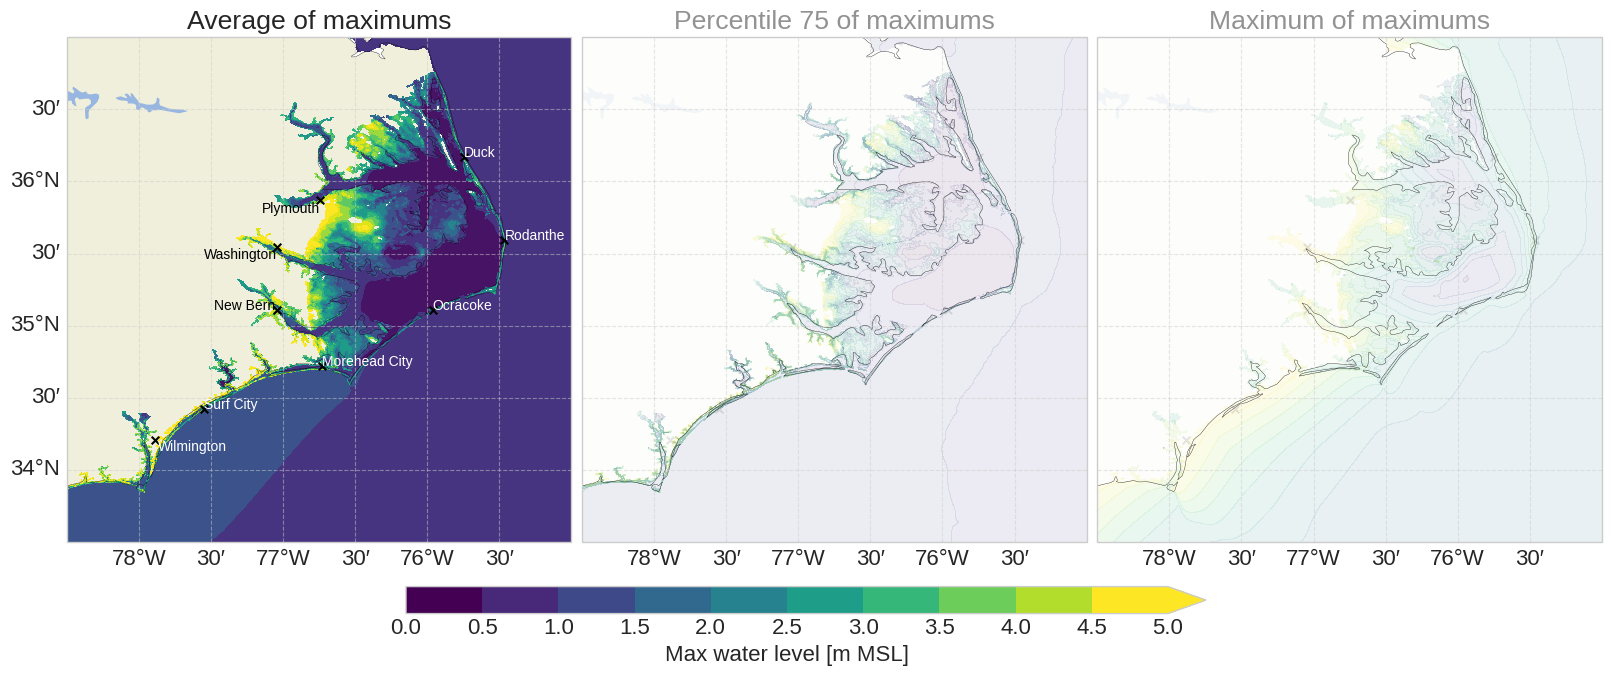

In [40]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 3, sharey = True)

cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.arange(0, 5.5, 0.5), cmap.N)

aux = np.nan_to_num(meanOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[0].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'Plymouth' or t == 'Washington':
        ax[0].text(xi, yi-0.01, t, size = 10, color = 'Black', ha='right', va = 'top')
    elif t == 'New Bern':
        ax[0].text(xi-0.01, yi, t, size = 10, color = 'Black', ha='right')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'white', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'white')
# coastalTowns.plot(ax = ax[0], c = 'k', marker = 'x')

aux = np.nan_to_num(per75OfMax.values, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max', alpha = 0.1)
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND, alpha = 0.1)
ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
ax[1].add_feature(cfeature.LAKES, alpha = 0.1)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x', alpha = 0.1)

aux = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[2].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max', alpha = 0.1)
ax[2].set_ylim([33.5, 37])
ax[2].set_xlim([-78.5, -75])
gl = ax[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[2].add_feature(cfeature.LAND, alpha = 0.1)
ax[2].add_feature(cfeature.COASTLINE,lw=0.25)
ax[2].add_feature(cfeature.LAKES, alpha = 0.1)
ax[2].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x', alpha = 0.1)

ax[2].set_title('Maximum of maximums', alpha = 0.5)
ax[1].set_title('Percentile 75 of maximums', alpha = 0.5)
ax[0].set_title('Average of maximums')

fig = ax[0].get_figure()
cax = fig.add_axes([0.25, 0.14, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Max water level [m MSL]', orientation = 'horizontal', extend = 'max')
loc = np.arange(0, 5.5, 0.5)
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 5.5, 0.5))

fig.savefig(r'../documents/waves_and_storm_surge/mapsofmaxs_a.png', dpi = 300, bbox_inches = 'tight')

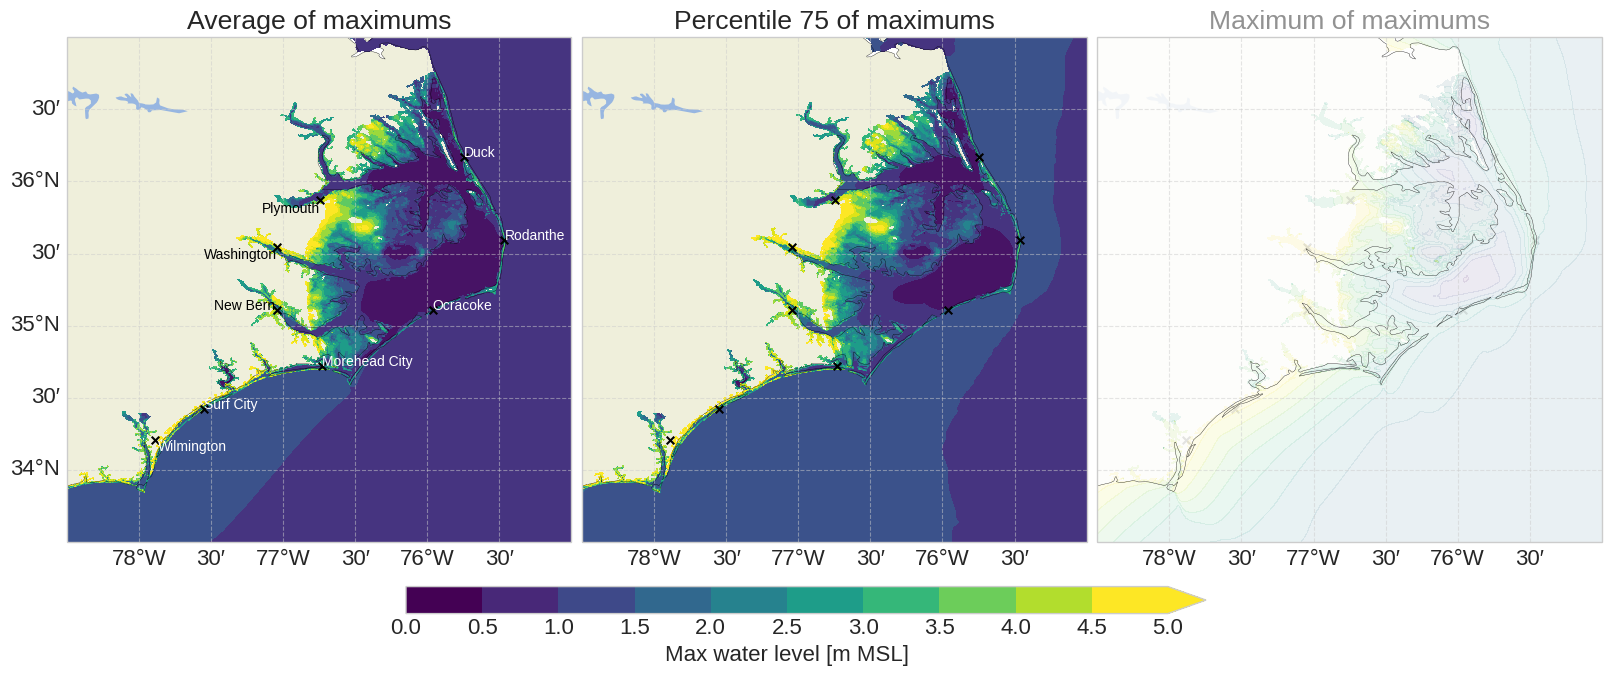

In [41]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 3, sharey = True)

cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.arange(0, 5.5, 0.5), cmap.N)
Both mapsTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'Plymouth' or t == 'Washington':
        ax[0].text(xi, yi-0.01, t, size = 10, color = 'Black', ha='right', va = 'top')
    elif t == 'New Bern':
        ax[0].text(xi-0.01, yi, t, size = 10, color = 'Black', ha='right')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'white', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'white')
# coastalTowns.plot(ax = ax[0], c = 'k', marker = 'x')

aux = np.nan_to_num(per75OfMax.values, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND)
ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
ax[1].add_feature(cfeature.LAKES)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

aux = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[2].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max', alpha = 0.1)
ax[2].set_ylim([33.5, 37])
ax[2].set_xlim([-78.5, -75])
gl = ax[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[2].add_feature(cfeature.LAND, alpha = 0.1)
ax[2].add_feature(cfeature.COASTLINE,lw=0.25)
ax[2].add_feature(cfeature.LAKES, alpha = 0.1)
ax[2].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x', alpha = 0.1)

ax[2].set_title('Maximum of maximums', alpha = 0.5)
ax[1].set_title('Percentile 75 of maximums')
ax[0].set_title('Average of maximums')

fig = ax[0].get_figure()
cax = fig.add_axes([0.25, 0.14, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Max water level [m MSL]', orientation = 'horizontal', extend = 'max')
loc = np.arange(0, 5.5, 0.5)
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 5.5, 0.5))

fig.savefig(r'../documents/waves_and_storm_surge/mapsofmaxs_b.png', dpi = 300, bbox_inches = 'tight')

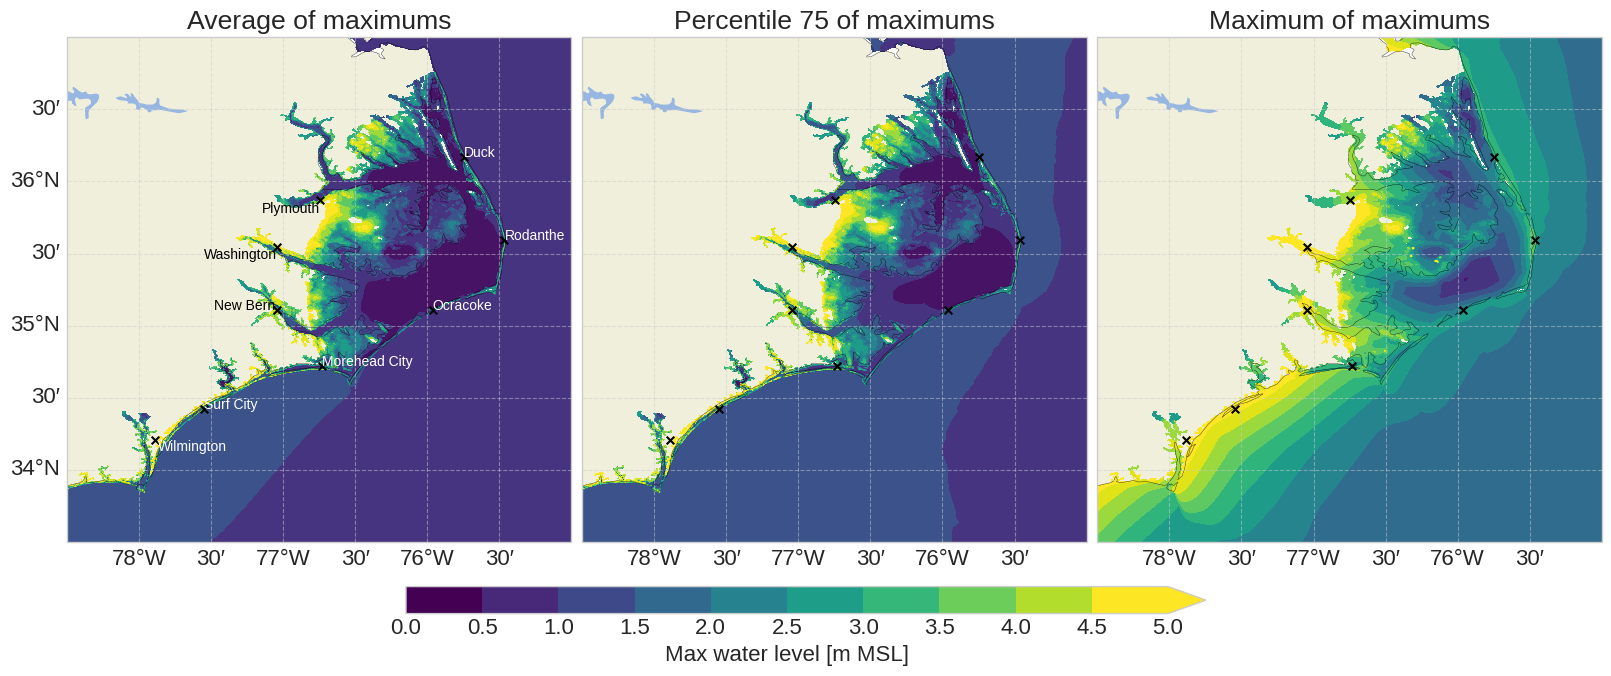

In [43]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 3, sharey = True)

cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.arange(0, 5.5, 0.5), cmap.N)

aux = np.nan_to_num(meanOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[0].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'Plymouth' or t == 'Washington':
        ax[0].text(xi, yi-0.01, t, size = 10, color = 'Black', ha='right', va = 'top')
    elif t == 'New Bern':
        ax[0].text(xi-0.01, yi, t, size = 10, color = 'Black', ha='right')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'white', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'white')
# coastalTowns.plot(ax = ax[0], c = 'k', marker = 'x')

aux = np.nan_to_num(per75OfMax.values, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND)
ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
ax[1].add_feature(cfeature.LAKES)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

aux = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[2].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[2].set_ylim([33.5, 37])
ax[2].set_xlim([-78.5, -75])
gl = ax[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[2].add_feature(cfeature.LAND)
ax[2].add_feature(cfeature.COASTLINE,lw=0.25)
ax[2].add_feature(cfeature.LAKES)
ax[2].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

ax[2].set_title('Maximum of maximums')
ax[1].set_title('Percentile 75 of maximums')
ax[0].set_title('Average of maximums')

fig = ax[0].get_figure()
cax = fig.add_axes([0.25, 0.14, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Max water level [m MSL]', orientation = 'horizontal', extend = 'max')
loc = np.arange(0, 5.5, 0.5)
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 5.5, 0.5))

fig.savefig(r'../documents/waves_and_storm_surge/mapsofmaxs_c.png', dpi = 300, bbox_inches = 'tight')

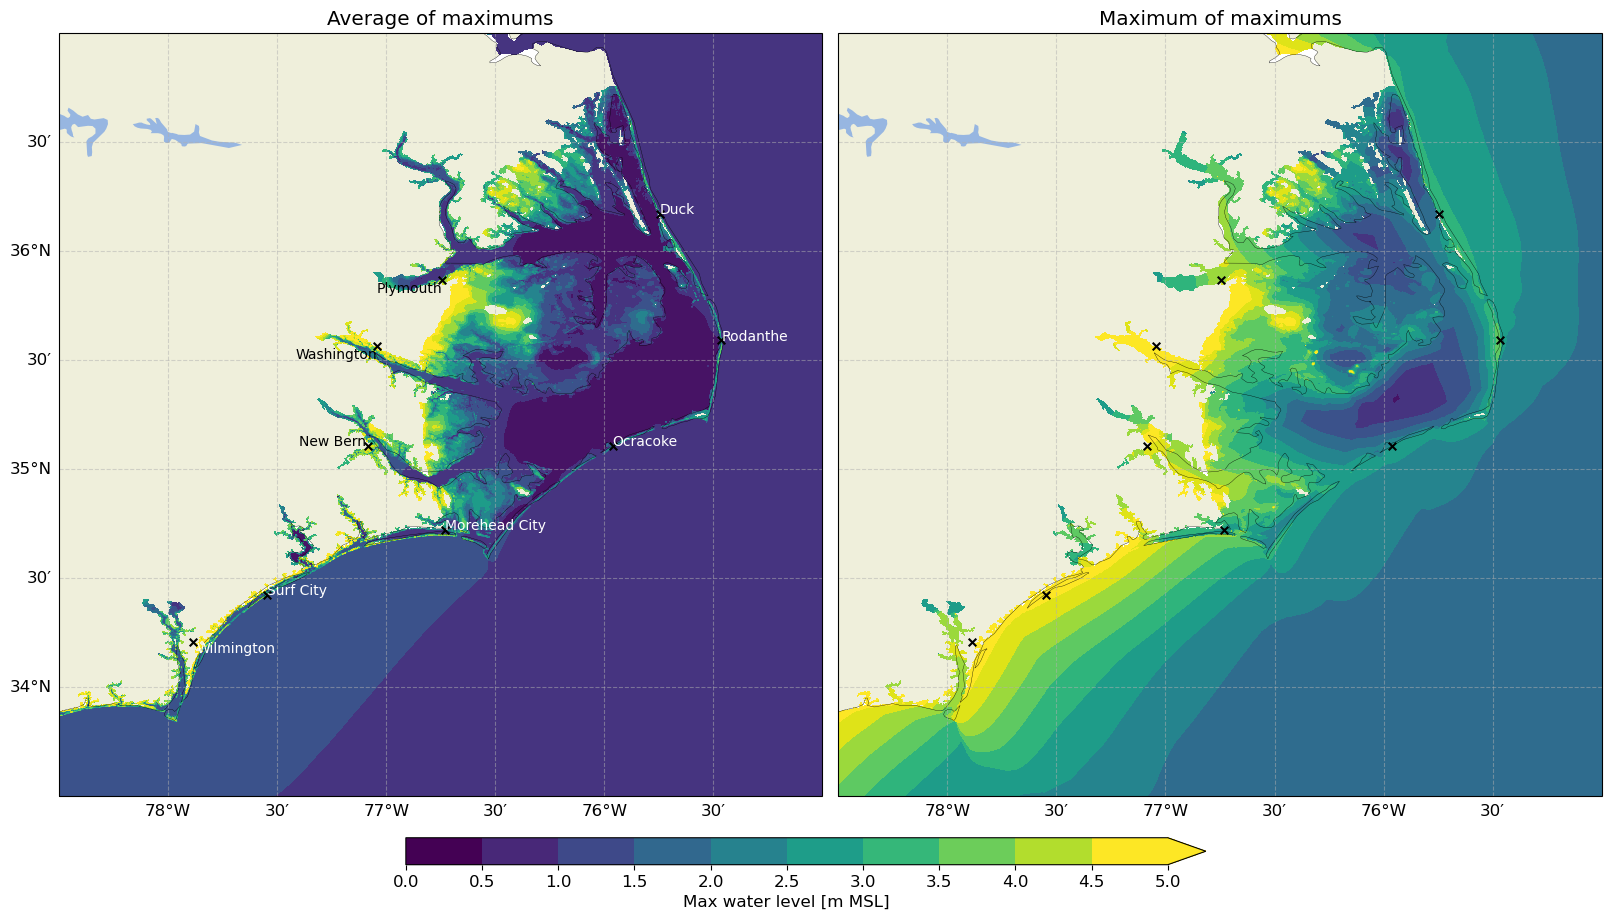

In [47]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 2, sharey = True)

cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.arange(0, 5.5, 0.5), cmap.N)

aux = np.nan_to_num(meanOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[0].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'Plymouth' or t == 'Washington':
        ax[0].text(xi, yi-0.01, t, size = 10, color = 'Black', ha='right', va = 'top')
    elif t == 'New Bern':
        ax[0].text(xi-0.01, yi, t, size = 10, color = 'Black', ha='right')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'white', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'white')
# coastalTowns.plot(ax = ax[0], c = 'k', marker = 'x')

# aux = np.nan_to_num(per75OfMax.values, nan = -99999.0).reshape(-1)
# contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
# ax[1].set_ylim([33.5, 37])
# ax[1].set_xlim([-78.5, -75])
# gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
# gl.top_labels = False
# gl.right_labels = False
# gl.left_labels = False
# ax[1].add_feature(cfeature.LAND)
# ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
# ax[1].add_feature(cfeature.LAKES)
# ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

aux = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND)
ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
ax[1].add_feature(cfeature.LAKES)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

ax[1].set_title('Maximum of maximums')
# ax[1].set_title('Percentile 75 of maximums')
ax[0].set_title('Average of maximums')

fig = ax[0].get_figure()
# cax = fig.add_axes([0.25, 0.12, 0.5, 0.03])
cax = fig.add_axes([0.25, 0.0, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Max water level [m MSL]', orientation = 'horizontal', extend = 'max')
loc = np.arange(0, 5.5, 0.5)
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 5.5, 0.5))

# fig.savefig(r'../documents/waves_and_storm_surge/mapsofmaxs_c.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/mapsofmaxs.png', dpi = 300, bbox_inches = 'tight')

In [11]:
with plt.rc_context({'font.size': 16}):
    fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                                constrained_layout=True, ncols = 2, sharey = True)

    cmap = plt.cm.viridis
    norm = colors.BoundaryNorm(np.arange(0, 5.5, 0.5), cmap.N)

    aux = np.nan_to_num(meanOfMax.values, nan = -99999.0).reshape(-1)
    contours = ax[0].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
    ax[0].set_ylim([33.5, 37])
    ax[0].set_xlim([-78.5, -75])
    gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
    gl.top_labels = False
    gl.right_labels = False
    ax[0].add_feature(cfeature.LAND)
    ax[0].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[0].add_feature(cfeature.LAKES)
    ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
    for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
        if t == 'Plymouth' or t == 'Washington':
            ax[0].text(xi, yi-0.01, t, size = 12, color = 'Black', ha='right', va = 'top')
        elif t == 'New Bern':
            ax[0].text(xi-0.01, yi, t, size = 12, color = 'Black', ha='right')
        elif t == 'Wilmington':
            ax[0].text(xi+0.02, yi, t, size = 12, color = 'white', va = 'top')
        else:
            ax[0].text(xi, yi, t, size = 12, color = 'white')
    # coastalTowns.plot(ax = ax[0], c = 'k', marker = 'x')

    # aux = np.nan_to_num(per75OfMax.values, nan = -99999.0).reshape(-1)
    # contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
    # ax[1].set_ylim([33.5, 37])
    # ax[1].set_xlim([-78.5, -75])
    # gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
    # gl.top_labels = False
    # gl.right_labels = False
    # gl.left_labels = False
    # ax[1].add_feature(cfeature.LAND)
    # ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
    # ax[1].add_feature(cfeature.LAKES)
    # ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

    aux = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
    contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
    ax[1].set_ylim([33.5, 37])
    ax[1].set_xlim([-78.5, -75])
    gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    ax[1].add_feature(cfeature.LAND)
    ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
    ax[1].add_feature(cfeature.LAKES)
    ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

    ax[1].set_title('Maximum of maximums')
    # ax[1].set_title('Percentile 75 of maximums')
    ax[0].set_title('Average of maximums')

    fig = ax[0].get_figure()
    # cax = fig.add_axes([0.25, 0.12, 0.5, 0.03])
    cax = fig.add_axes([0.25, 0.0, 0.5, 0.03])
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm._A = []
    cb = fig.colorbar(sm, cax = cax, label = 'Max water level [m MSL]', orientation = 'horizontal', extend = 'max')
    loc = np.arange(0, 5.5, 0.5)
    cb.set_ticks(loc)
    cb.set_ticklabels(np.arange(0, 5.5, 0.5))

    fig.savefig(r'../documents/defense/mapsofmaxs.png', dpi = 300, bbox_inches = 'tight')

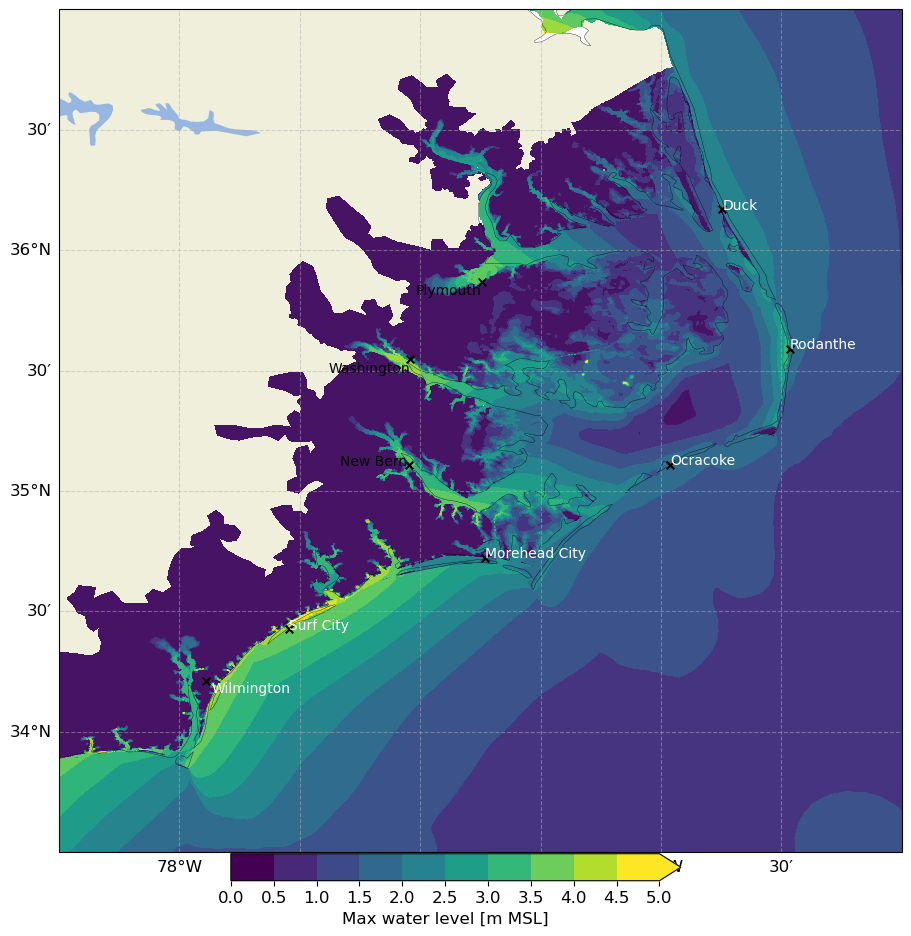

In [9]:
fig, ax = plt.subplots(figsize = (9, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 1, sharey = True)

cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.arange(0, 5.5, 0.5), cmap.N)

aux0 = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
aux1 = np.nan_to_num(meanOfMax.values, nan = -99999.0).reshape(-1)
contours = ax.tricontourf(newMeshTri, (aux0-aux1), levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
ax.set_ylim([33.5, 37])
ax.set_xlim([-78.5, -75])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,lw=0.25)
ax.add_feature(cfeature.LAKES)
ax.scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'Plymouth' or t == 'Washington':
        ax.text(xi, yi-0.01, t, size = 10, color = 'Black', ha='right', va = 'top')
    elif t == 'New Bern':
        ax.text(xi-0.01, yi, t, size = 10, color = 'Black', ha='right')
    elif t == 'Wilmington':
        ax.text(xi+0.02, yi, t, size = 10, color = 'white', va = 'top')
    else:
        ax.text(xi, yi, t, size = 10, color = 'white')
# coastalTowns.plot(ax = ax[0], c = 'k', marker = 'x')

# aux = np.nan_to_num(per75OfMax.values, nan = -99999.0).reshape(-1)
# contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
# ax[1].set_ylim([33.5, 37])
# ax[1].set_xlim([-78.5, -75])
# gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
# gl.top_labels = False
# gl.right_labels = False
# gl.left_labels = False
# ax[1].add_feature(cfeature.LAND)
# ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
# ax[1].add_feature(cfeature.LAKES)
# ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

# aux = np.nan_to_num(maxOfMax.values, nan = -99999.0).reshape(-1)
# contours = ax[1].tricontourf(newMeshTri, aux, levels = np.arange(0, 5.5, 0.5), cmap = cmap, extend = 'max')
# ax[1].set_ylim([33.5, 37])
# ax[1].set_xlim([-78.5, -75])
# gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
# gl.top_labels = False
# gl.right_labels = False
# gl.left_labels = False
# ax[1].add_feature(cfeature.LAND)
# ax[1].add_feature(cfeature.COASTLINE,lw=0.25)
# ax[1].add_feature(cfeature.LAKES)
# ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')

# ax[1].set_title('Maximum of maximums')
# # ax[1].set_title('Percentile 75 of maximums')
# ax[0].set_title('Average of maximums')

fig = ax.get_figure()
# cax = fig.add_axes([0.25, 0.12, 0.5, 0.03])
cax = fig.add_axes([0.25, 0.0, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Max water level [m MSL]', orientation = 'horizontal', extend = 'max')
loc = np.arange(0, 5.5, 0.5)
cb.set_ticks(loc)
cb.set_ticklabels(np.arange(0, 5.5, 0.5))

# # fig.savefig(r'../documents/waves_and_storm_surge/mapsofmaxs_c.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(r'..//documents/thesis/mapsofmaxs.png', dpi = 300, bbox_inches = 'tight')

In [10]:
dfquants = pd.read_csv(r'../models/adcirc/concorde/batch02/_postprocessing/all_maxEle63_below10_subsetBoxNC_nonExceProbDist.csv', index_col = 0)

In [11]:
mdist = cdist(list(zip(dfNodesInside['x'], dfNodesInside['y'])), [(-77.035, 35.1037), (-76.982, 35.0223)])

In [15]:
float(f(2))*100

14.723520569134413

In [16]:
float(f(4))*100

0.4829999030101802

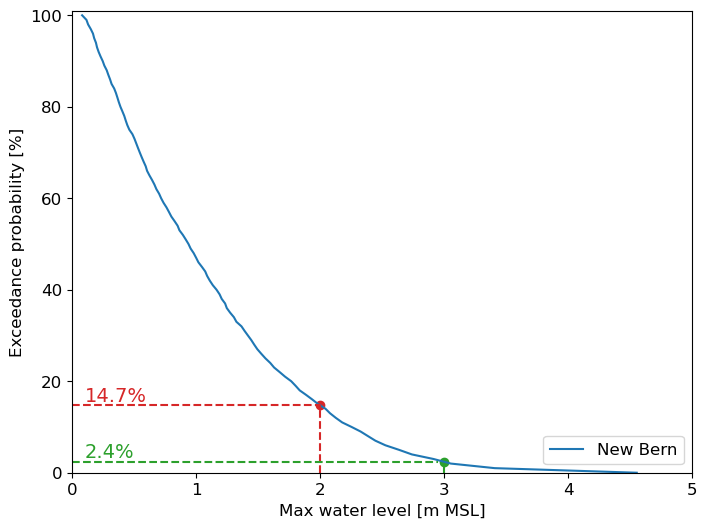

In [20]:
cl = mdist[:, 1].argmin()
dummy = pd.DataFrame({'prob': 1 - np.arange(0, 1.01, 0.01)}, index = dfquants.loc[cl, :].values)
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(dummy, label = 'New Bern')
f = interpolate.interp1d(dummy.index, dummy['prob'])
prob2m = f(2)
prob3m = f(3)
ax.scatter([2], [prob2m], color = ccolors[3])
ax.scatter([3], [prob3m], color = ccolors[2])
ax.axvline(x = 2, ymin = 0, ymax = float(prob2m), color = ccolors[3], ls = '--')
ax.axhline(y = prob2m, xmin = 0, xmax = 0.40, color = ccolors[3], ls = '--')
ax.text(0.1, prob2m+0.01, f'{prob2m*100:0.1f}%', size = 14, color = ccolors[3])
ax.text(0.1, prob3m+0.01, f'{prob3m*100:0.1f}%', size = 14, color = ccolors[2])
ax.axvline(x = 3, ymin = 0, ymax = float(prob3m), color = ccolors[2], ls = '--')
ax.axhline(y = prob3m, xmin = 0, xmax = 0.59, color = ccolors[2], ls = '--')
ax.set_ylim(0, 1.01)
ax.set_xlim(0.0, 5)
ax.set_yticklabels([f'{x*100:0.0f}' for x in ax.get_yticks()]);
ax.set_xlabel('Max water level [m MSL]')
ax.set_ylabel('Exceedance probability [%]')
ax.legend(frameon = True, loc = 'lower right')
# fig.savefig(r'../documents/waves_and_storm_surge/prob_distribution_newbern.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/prob_distribution_newbern.png', dpi = 300, bbox_inches = 'tight')

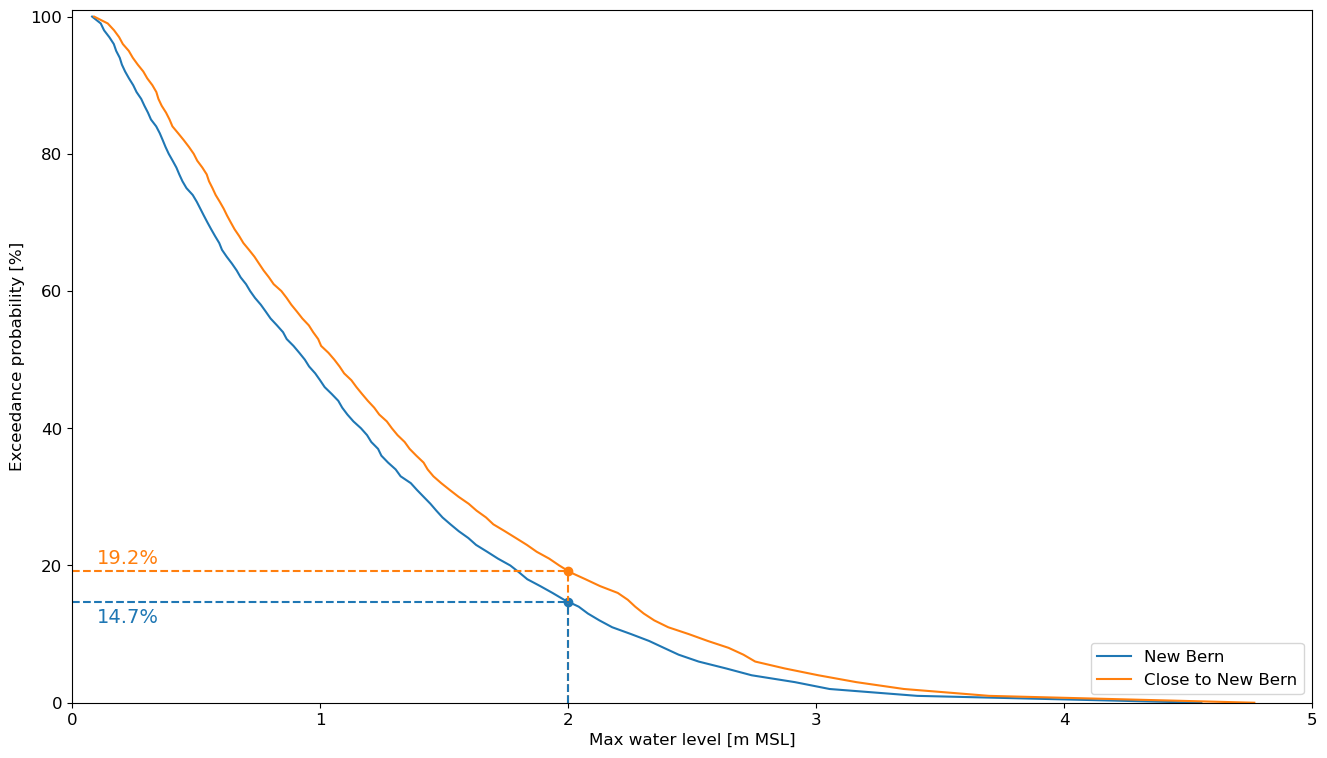

In [42]:
cl0 = mdist[:, 0].argmin()
cl1 = mdist[:, 1].argmin()
dummy0 = pd.DataFrame({'prob': 1 - np.arange(0, 1.01, 0.01)}, index = dfquants.loc[cl0, :].values)
dummy1 = pd.DataFrame({'prob': 1 - np.arange(0, 1.01, 0.01)}, index = dfquants.loc[cl1, :].values)

fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(dummy1, label = 'New Bern', color = ccolors[0])
ax.plot(dummy0, label = 'Close to New Bern', color = ccolors[1])
f1 = interpolate.interp1d(dummy1.index, dummy1['prob'])
f0 = interpolate.interp1d(dummy0.index, dummy0['prob'])
prob0 = float(f0(2))
prob1 = float(f1(2))

ax.scatter([2], [prob0], color = ccolors[1])
ax.axvline(x = 2, ymin = 0, ymax = float(prob0), color = ccolors[1], ls = '--')
ax.axhline(y = prob0, xmin = 0, xmax = 0.4, color = ccolors[1], ls = '--')

ax.scatter([2], [prob1], color = ccolors[0])
ax.axvline(x = 2, ymin = 0, ymax = float(prob1), color = ccolors[0], ls = '--')
ax.axhline(y = prob1, xmin = 0, xmax = 0.4, color = ccolors[0], ls = '--')


ax.text(0.1, prob1 - 0.03, f'{prob1*100:0.1f}%', size = 14, color = ccolors[0])
ax.text(0.1, prob0 + 0.01, f'{prob0*100:0.1f}%', size = 14, color = ccolors[1])
ax.set_ylim(0, 1.01)
ax.set_xlim(0.0, 5)
ax.set_yticklabels([f'{x*100:0.0f}' for x in ax.get_yticks()]);
ax.set_xlabel('Max water level [m MSL]')
ax.set_ylabel('Exceedance probability [%]')
ax.legend(frameon = True, loc = 'lower right')
# fig.savefig(r'../documents/waves_and_storm_surge/prob_distribution_newbern_example.png', dpi = 300, bbox_inches = 'tight')

In [43]:
probs1m = []
probs2m = []
probs3m = []
yvals = [1 - float(x) for x in dfquants.columns]
for i in tqdm(dfquants.index):
    f = interpolate.interp1d(dfquants.loc[i, :], yvals, fill_value=0, bounds_error=False)
    probs1m.append(float(f(1)))
    probs2m.append(float(f(2)))
    probs3m.append(float(f(3)))

100%|██████████| 898949/898949 [04:15<00:00, 3515.78it/s]


In [44]:
coastalTowns.loc[3, 'x'] = coastalTowns.loc[3, 'x'] - 0.04
## new bern

In [45]:
coastalTowns.loc[7, 'y'] = coastalTowns.loc[7, 'y'] + 0.02
## washington

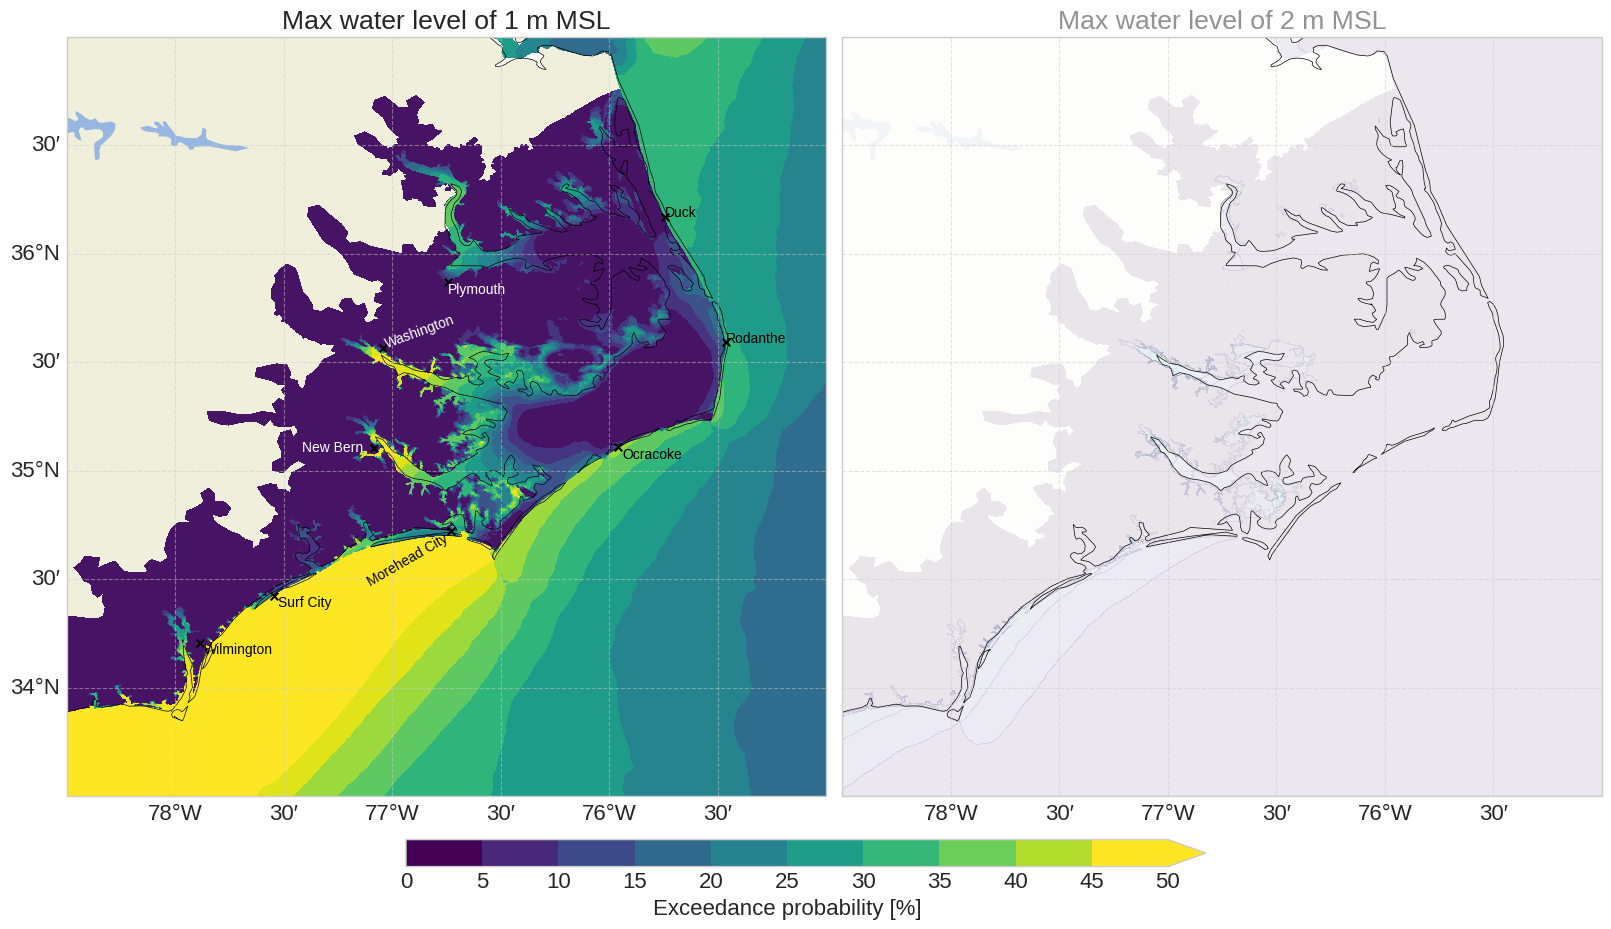

In [50]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 2, sharey = True,
                            gridspec_kw={'width_ratios': [1, 1]})

cmap = plt.cm.viridis
normArr = np.arange(0.0, 0.55, 0.05)
norm = colors.BoundaryNorm(normArr, cmap.N)

aux = np.nan_to_num(probs1m, nan = -99999.0).reshape(-1)
contours = ax[0].tricontourf(newMeshTri, aux, levels = normArr, cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.5)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'New Bern':
        ax[0].text(xi-0.05, yi, t, size = 10, color = 'White', ha='right', va='center')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'Black', ha='left', va='top')
    elif t == 'Morehead City':
        ax[0].text(xi, yi, t, size = 10, color = 'Black', ha='right', va='top', rotation=30)
    elif t == 'Ocracoke' or t == 'Surf City':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'Black', ha='left', va='top')
    elif t == 'Washington':
        ax[0].text(xi, yi, t, size = 10, color = 'White', ha='left', rotation=20)
    elif t == 'Plymouth':
        ax[0].text(xi, yi, t, size = 10, color = 'White', ha='left', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'Black', ha='left')
#
aux = np.nan_to_num(probs2m, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = normArr, cmap = cmap, extend = 'max', alpha = 0.1)
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND, alpha = 0.1)
ax[1].add_feature(cfeature.COASTLINE,lw=0.5)
ax[1].add_feature(cfeature.LAKES, alpha = 0.1)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'w', s = 30, marker = 'x', alpha = 0.1)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('Max water level of 1 m MSL')
ax[1].set_title('Max water level of 2 m MSL', alpha = 0.5)

fig = ax[0].get_figure()
cax = fig.add_axes([0.25, 0.0, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Exceedance probability [%]', orientation = 'horizontal', extend = 'max')
cb.set_ticks(normArr)
cb.set_ticklabels([f'{100*x:0.0f}' for x in normArr])

fig.savefig(r'../documents/waves_and_storm_surge/mapprobs_a.png', dpi = 300, bbox_inches = 'tight')

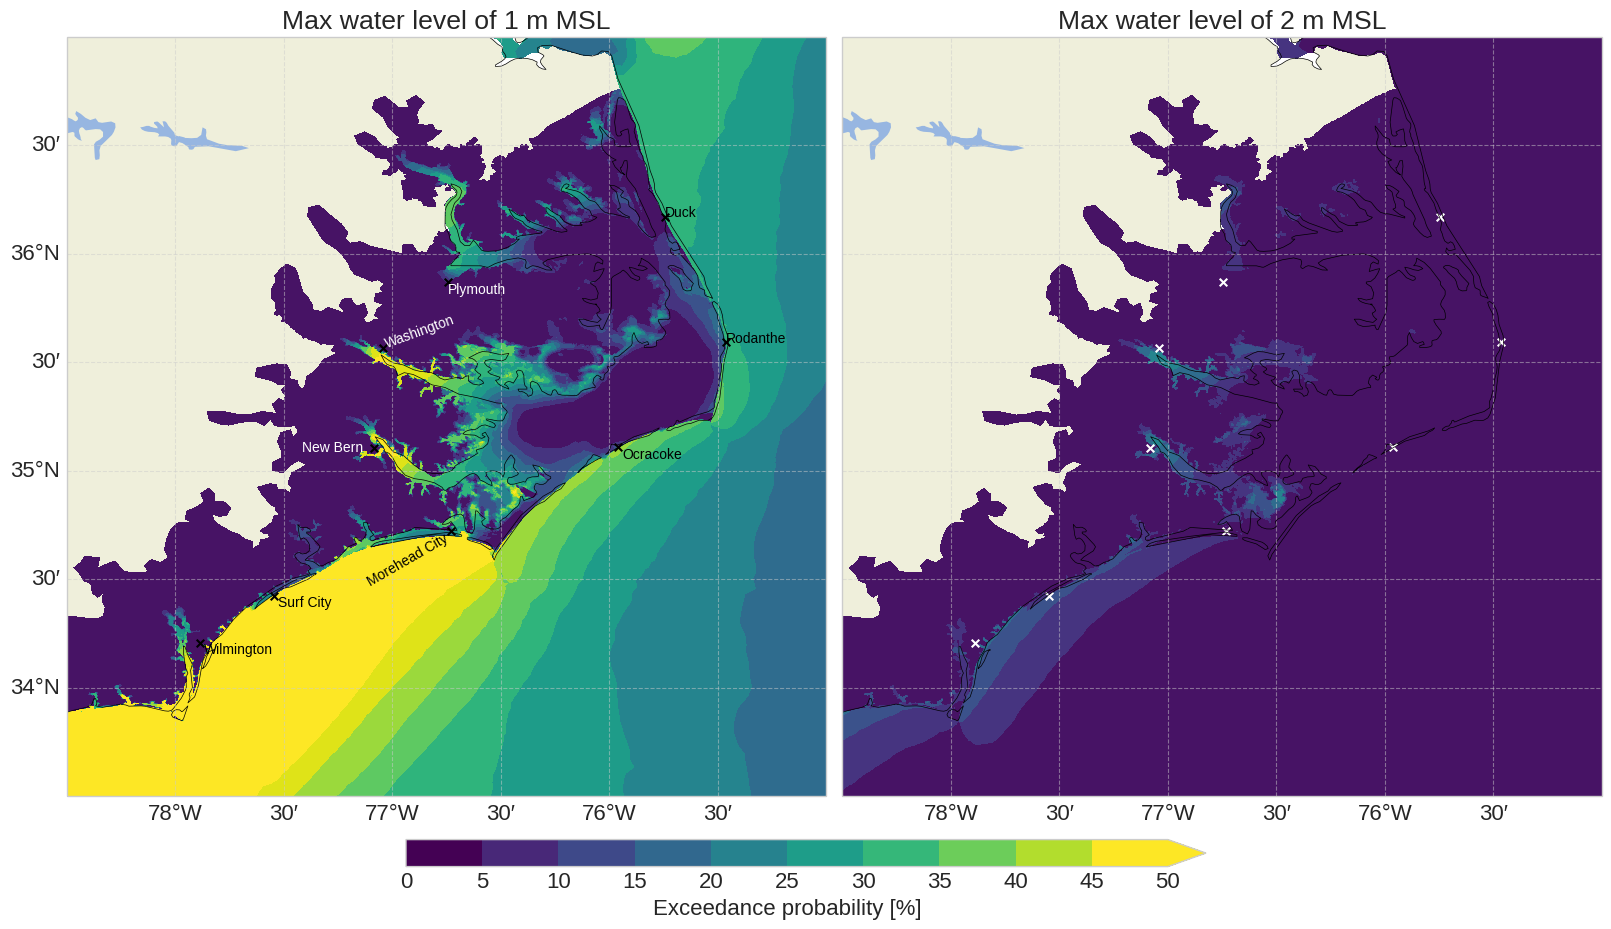

In [52]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 2, sharey = True,
                            gridspec_kw={'width_ratios': [1, 1]})

cmap = plt.cm.viridis
normArr = np.arange(0.0, 0.55, 0.05)
norm = colors.BoundaryNorm(normArr, cmap.N)

aux = np.nan_to_num(probs1m, nan = -99999.0).reshape(-1)
contours = ax[0].tricontourf(newMeshTri, aux, levels = normArr, cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.5)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'New Bern':
        ax[0].text(xi-0.05, yi, t, size = 10, color = 'White', ha='right', va='center')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'Black', ha='left', va='top')
    elif t == 'Morehead City':
        ax[0].text(xi, yi, t, size = 10, color = 'Black', ha='right', va='top', rotation=30)
    elif t == 'Ocracoke' or t == 'Surf City':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'Black', ha='left', va='top')
    elif t == 'Washington':
        ax[0].text(xi, yi, t, size = 10, color = 'White', ha='left', rotation=20)
    elif t == 'Plymouth':
        ax[0].text(xi, yi, t, size = 10, color = 'White', ha='left', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'Black', ha='left')
#
aux = np.nan_to_num(probs2m, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = normArr, cmap = cmap, extend = 'max')
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND)
ax[1].add_feature(cfeature.COASTLINE,lw=0.5)
ax[1].add_feature(cfeature.LAKES)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'w', s = 30, marker = 'x')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('Max water level of 1 m MSL')
ax[1].set_title('Max water level of 2 m MSL')

fig = ax[0].get_figure()
cax = fig.add_axes([0.25, 0.0, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Exceedance probability [%]', orientation = 'horizontal', extend = 'max')
cb.set_ticks(normArr)
cb.set_ticklabels([f'{100*x:0.0f}' for x in normArr])

fig.savefig(r'../documents/waves_and_storm_surge/mapprobs_b.png', dpi = 300, bbox_inches = 'tight')

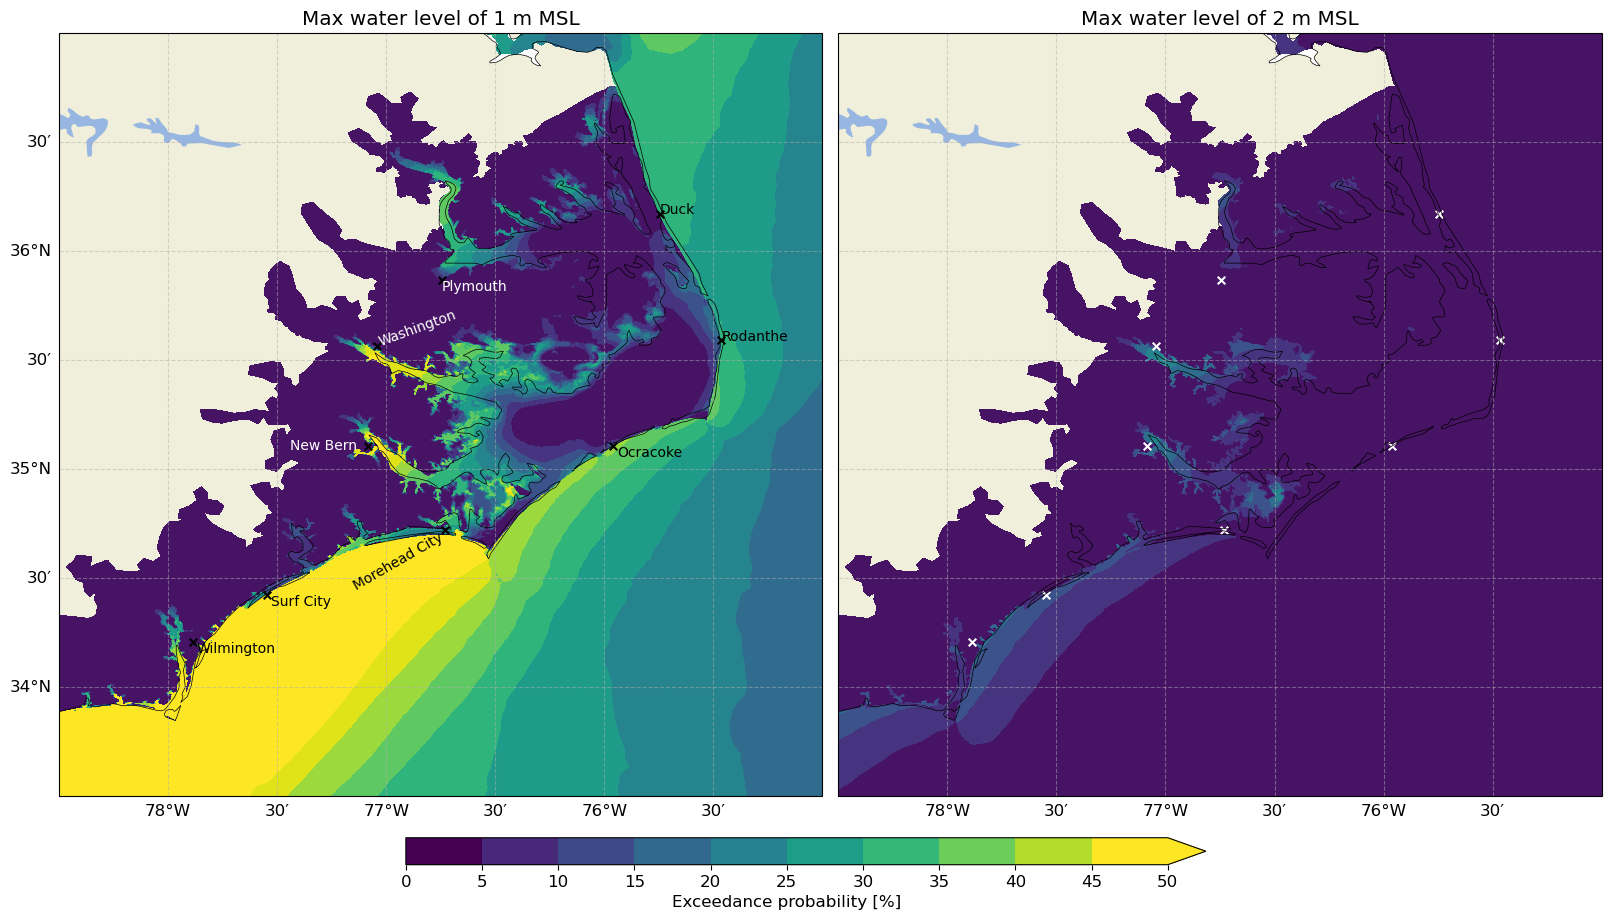

In [46]:
fig, ax = plt.subplots(figsize = (16, 9), subplot_kw={'projection': ccrs.PlateCarree()}, 
                            constrained_layout=True, ncols = 2, sharey = True,
                            gridspec_kw={'width_ratios': [1, 1]})

cmap = plt.cm.viridis
normArr = np.arange(0.0, 0.55, 0.05)
norm = colors.BoundaryNorm(normArr, cmap.N)

aux = np.nan_to_num(probs1m, nan = -99999.0).reshape(-1)
contours = ax[0].tricontourf(newMeshTri, aux, levels = normArr, cmap = cmap, extend = 'max')
ax[0].set_ylim([33.5, 37])
ax[0].set_xlim([-78.5, -75])
gl = ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
ax[0].add_feature(cfeature.LAND)
ax[0].add_feature(cfeature.COASTLINE,lw=0.5)
ax[0].add_feature(cfeature.LAKES)
ax[0].scatter(coastalTowns['x'], coastalTowns['y'], c = 'k', s = 30, marker = 'x')
for t, xi, yi in zip(coastalTowns['Name'], coastalTowns['x'], coastalTowns['y']):
    if t == 'New Bern':
        ax[0].text(xi-0.05, yi, t, size = 10, color = 'White', ha='right', va='center')
    elif t == 'Wilmington':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'Black', ha='left', va='top')
    elif t == 'Morehead City':
        ax[0].text(xi, yi, t, size = 10, color = 'Black', ha='right', va='top', rotation=30)
    elif t == 'Ocracoke' or t == 'Surf City':
        ax[0].text(xi+0.02, yi, t, size = 10, color = 'Black', ha='left', va='top')
    elif t == 'Washington':
        ax[0].text(xi, yi, t, size = 10, color = 'White', ha='left', rotation=20)
    elif t == 'Plymouth':
        ax[0].text(xi, yi, t, size = 10, color = 'White', ha='left', va = 'top')
    else:
        ax[0].text(xi, yi, t, size = 10, color = 'Black', ha='left')
#
aux = np.nan_to_num(probs2m, nan = -99999.0).reshape(-1)
contours = ax[1].tricontourf(newMeshTri, aux, levels = normArr, cmap = cmap, extend = 'max')
ax[1].set_ylim([33.5, 37])
ax[1].set_xlim([-78.5, -75])
gl = ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--') 
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax[1].add_feature(cfeature.LAND)
ax[1].add_feature(cfeature.COASTLINE,lw=0.5)
ax[1].add_feature(cfeature.LAKES)
ax[1].scatter(coastalTowns['x'], coastalTowns['y'], c = 'w', s = 30, marker = 'x')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('Max water level of 1 m MSL')
ax[1].set_title('Max water level of 2 m MSL')

fig = ax[0].get_figure()
cax = fig.add_axes([0.25, 0.0, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm._A = []
cb = fig.colorbar(sm, cax = cax, label = 'Exceedance probability [%]', orientation = 'horizontal', extend = 'max')
cb.set_ticks(normArr)
cb.set_ticklabels([f'{100*x:0.0f}' for x in normArr])

# fig.savefig(r'../documents/waves_and_storm_surge/mapprobs_b.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(r'..//documents/thesis/mapprobs.png', dpi = 300, bbox_inches = 'tight')